# Influence LXe Rayleigh Scattering Length on the LCE

In [1]:
## Imports:

import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline
import concurrent.futures

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from numpy import exp
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.patches as patches
import matplotlib.cbook as cbook
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
## Function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


def remove_duplicate(input_list, inputcritical_list): 
    final_list = []
    finalcritical_list = []
    for i in range(0, len(inputcritical_list)): 
        if inputcritical_list[i] not in finalcritical_list: 
            finalcritical_list.append(inputcritical_list[i]) 
            final_list.append(input_list[i])
    return final_list 

In [3]:
## PMT properties and physics:

QE_PMT0 = 0.325
QE_PMT1 = 0.3
QE_PMT2 = 0.3
QE_PMT3 = 0.3
QE_PMT4 = 0.3
QE_PMT5 = 0.3
QE_PMT6 = 0.3
QE_PMT7 = 0.3
QE_Bottom = QE_PMT0
QE_Top = 0.3

CE_PMT0 = 0.95
CE_PMT1 = 0.7
CE_PMT2 = 0.7
CE_PMT3 = 0.7
CE_PMT4 = 0.7
CE_PMT5 = 0.7
CE_PMT6 = 0.7
CE_PMT7 = 0.7
CE_Bottom = CE_PMT0
CE_Top = 0.7

W = 1/(1302.808447/32.1517) # 1/W = photons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/W  = '+str(1/W)+' ph/keV')
We = 1/(1045.457843/32.1517) # 1/W = electrons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/We = '+str(1/We)+' e/keV')

W0 = 1/(2195.519/32.1517) # 1/W = photons/keV @ 32.1517 keV, 0.0001 V/cm, ER
print('1/W0  = '+str(1/W0)+' ph/keV')

1/W  = 40.52067066438166 ph/keV
1/We = 32.51640949001141 e/keV
1/W0  = 68.28624924965087 ph/keV


## Imports and data processing

In [4]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Simulation_Data/LCE/*.root
#! ls ../../Simulation_Data/Modification_Spacer_3/*.root
! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/*.root

'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_100.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_10.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_15.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_20.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_30.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeR

In [5]:
b_preprocessed = True

if b_preprocessed == False:
    
    ## Selection of path with files to be analysed
    from os import listdir
    from os.path import isfile, join
    path = "/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength"
    files = [f for f in listdir(path) if isfile(join(path, f))]
    #files = files[0:3]

    ## Initialize empty dataframe
    opticals = pd.DataFrame({'RPTFE' : [], 'LXeAbs' : [], 'LXeRayScatterLength' : [], 'LCE_b' : [],'LCE_t' : [],'LCE_a' : []})

    counter = 0
    for file in files:

        ## Selection of file to be analyzed:
        #file = "optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100.root"
        filename = path+"/"+file
        #filenameprefix = file[:-5]    
        #print(filenameprefix)

        ## Extraction of optical parameters from filename
        RPTFE = float(file[file.find("RPTFE")+5 : file.find("_", file.find("RPTFE")+5)])
        LXeAbs = float(file[file.find("LXeAbs")+6 : file.find("_", file.find("LXeAbs")+6)])
        LXeRayScatterLength = float(file[file.find("LXeRayScatterLength")+20 : file.find(".root")])

        ## Import as pandas dataframes and write to compressed dataframe
        branches= ['nbpmthits','ntpmthits'] # Be careful that the branches are also initilized in _chunk_collect
        executor = concurrent.futures.ThreadPoolExecutor(8)
        _chunk_collect = pd.DataFrame({'nbpmthits' : [],'ntpmthits' : []}) # Initialize empty data frame
        for _chunk in uproot.iterate(filename, "events/events",branches, entrysteps=100000, 
                                               outputtype=pd.DataFrame, executor=executor):
            _chunk.columns=branches
            _chunk_collect = _chunk_collect.append(_chunk)
        LCE_b = _chunk_collect["nbpmthits"].mean()
        LCE_t = _chunk_collect["ntpmthits"].mean()
        LCE_a = LCE_b + LCE_t
        opticals = opticals.append(pd.DataFrame({'RPTFE' : [RPTFE], 'LXeAbs' : [LXeAbs], 'LXeRayScatterLength' : [LXeRayScatterLength], 'LCE_b' : [LCE_b],'LCE_t' : [LCE_t],'LCE_a' : [LCE_a]}), ignore_index=True)
        del(_chunk)
        del(_chunk_collect)
        
        counter += 1
        print(str(round(100*counter / len(files),1))+'%', end = ' ')

    ## Derive DE and LY
    opticals['DE_b'] = opticals['LCE_b'] * QE_Bottom * CE_Bottom
    opticals['DE_t'] = opticals['LCE_t'] * QE_Top * CE_Top
    opticals['DE_a'] = opticals['DE_b'] + opticals['DE_t']
    opticals['LY_b'] = opticals['DE_b']/W
    opticals['LY_t'] = opticals['DE_t']/W
    opticals['LY_a'] = opticals['LY_b'] + opticals['LY_t']
    opticals['LY0_b'] = opticals['DE_b']/W0
    opticals['LY0_t'] = opticals['DE_t']/W0
    opticals['LY0_a'] = opticals['LY0_b'] + opticals['LY0_t']

    ## Save to pickle file
    opticals.to_pickle("Influence_LXeRayScatterLength.pkl")

if b_preprocessed == True:
    opticals = pd.read_pickle("proc/Influence_LXeRayScatterLength.pkl")

print('Done.')
opticals

Done.


RPTFE  LXeAbs  LXeRayScatterLength     LCE_b     LCE_t     LCE_a  \
0    0.95   100.0                 10.0  0.246601  0.042308  0.288909   
1    0.99   100.0                 10.0  0.272691  0.047051  0.319742   
2    0.95  1000.0                 10.0  0.288526  0.048265  0.336792   
3    0.95  1000.0                100.0  0.303129  0.041326  0.344454   
4    0.95  1000.0                 15.0  0.293630  0.046209  0.339839   
5    0.95  1000.0                 20.0  0.296497  0.044917  0.341415   
6    0.95  1000.0                 30.0  0.299242  0.043407  0.342649   
7    0.95  1000.0                  5.0  0.273745  0.052956  0.326701   
8    0.95  1000.0                 50.0  0.301271  0.042187  0.343458   
9    0.95   100.0                100.0  0.260775  0.036659  0.297434   
10   0.95   100.0                 15.0  0.251732  0.040387  0.292119   
11   0.95   100.0                 20.0  0.254445  0.039512  0.293957   
12   0.95   100.0                 30.0  0.256910  0.038286  0.295196   
13   0.95   100.0                  5.0  0.231999  0.045835  0.277834   
14   0.95   100.0                 50.0  0.259172  0.037416  0.296588   
15   0.99  1000.0                 10.0  0.324269  0.054792  0.379061   
16   0.99  1000.0                100.0  0.340131  0.046449  0.386579   
17   0.99  1000.0                 15.0  0.329765  0.052099  0.381865   
18   0.99  1000.0                 20.0  0.332848  0.050613  0.383462   
19   0.99  1000.0                 30.0  0.336178  0.048887  0.385065   
20   0.99  1000.0                  5.0  0.308805  0.060487  0.369293   
21   0.99  1000.0                 50.0  0.338157  0.047480  0.385637   
22   0.99   100.0                100.0  0.287664  0.040579  0.328243   
23   0.99   100.0                 15.0  0.278110  0.044992  0.323102   
24   0.99   100.0                 20.0  0.280775  0.043886  0.324661   
25   0.99   100.0                 30.0  0.283842  0.042447  0.326289   
26   0.99   100.0                  5.0  0.257500  0.051249  0.308749   
27   0.99   100.0                 50.0  0.286281  0.041462  0.327742   

        DE_b      DE_t      DE_a      LY_b      LY_t      LY_a     LY0_b  \
0   0.076138  0.008885  0.085023  3.085160  0.360016  3.445176  5.199174   
1   0.084193  0.009881  0.094074  3.411565  0.400376  3.811940  5.749237   
2   0.089082  0.010136  0.099218  3.609680  0.410707  4.020387  6.083105   
3   0.093591  0.008678  0.102269  3.792370  0.351653  4.144022  6.390977   
4   0.090658  0.009704  0.100362  3.673536  0.393206  4.066742  6.190717   
5   0.091544  0.009433  0.100976  3.709407  0.382215  4.091622  6.251167   
6   0.092391  0.009115  0.101506  3.743743  0.369362  4.113104  6.309031   
7   0.084519  0.011121  0.095640  3.424755  0.450622  3.875377  5.771465   
8   0.093017  0.008859  0.101877  3.769130  0.358984  4.128114  6.351813   
9   0.080514  0.007698  0.088213  3.262494  0.311944  3.574438  5.498020   
10  0.077722  0.008481  0.086204  3.149360  0.343668  3.493028  5.307365   
11  0.078560  0.008298  0.086858  3.183300  0.336225  3.519525  5.364560   
12  0.079321  0.008040  0.087361  3.214140  0.325789  3.539928  5.416533   
13  0.071630  0.009625  0.081255  2.902482  0.390028  3.292510  4.891321   
14  0.080019  0.007857  0.087877  3.242439  0.318383  3.560822  5.464224   
15  0.100118  0.011506  0.111624  4.056851  0.466244  4.523094  6.836686   
16  0.105015  0.009754  0.114769  4.255290  0.395247  4.650537  7.171100   
17  0.101815  0.010941  0.112756  4.125614  0.443331  4.568944  6.952567   
18  0.102767  0.010629  0.113396  4.164183  0.430686  4.594869  7.017565   
19  0.103795  0.010266  0.114061  4.205839  0.415994  4.621832  7.087764   
20  0.095344  0.012702  0.108046  3.863389  0.514709  4.378098  6.510661   
21  0.104406  0.009971  0.114377  4.230604  0.404021  4.634625  7.129499   
22  0.088816  0.008522  0.097338  3.598888  0.345302  3.944190  6.064919   
23  0.085867  0.009448  0.095315  3.479372  0.382850  3.862221  5.863507   
24  0.086689  0

In [6]:
plt.rcParams['axes.axisbelow'] = True

## Evaluation

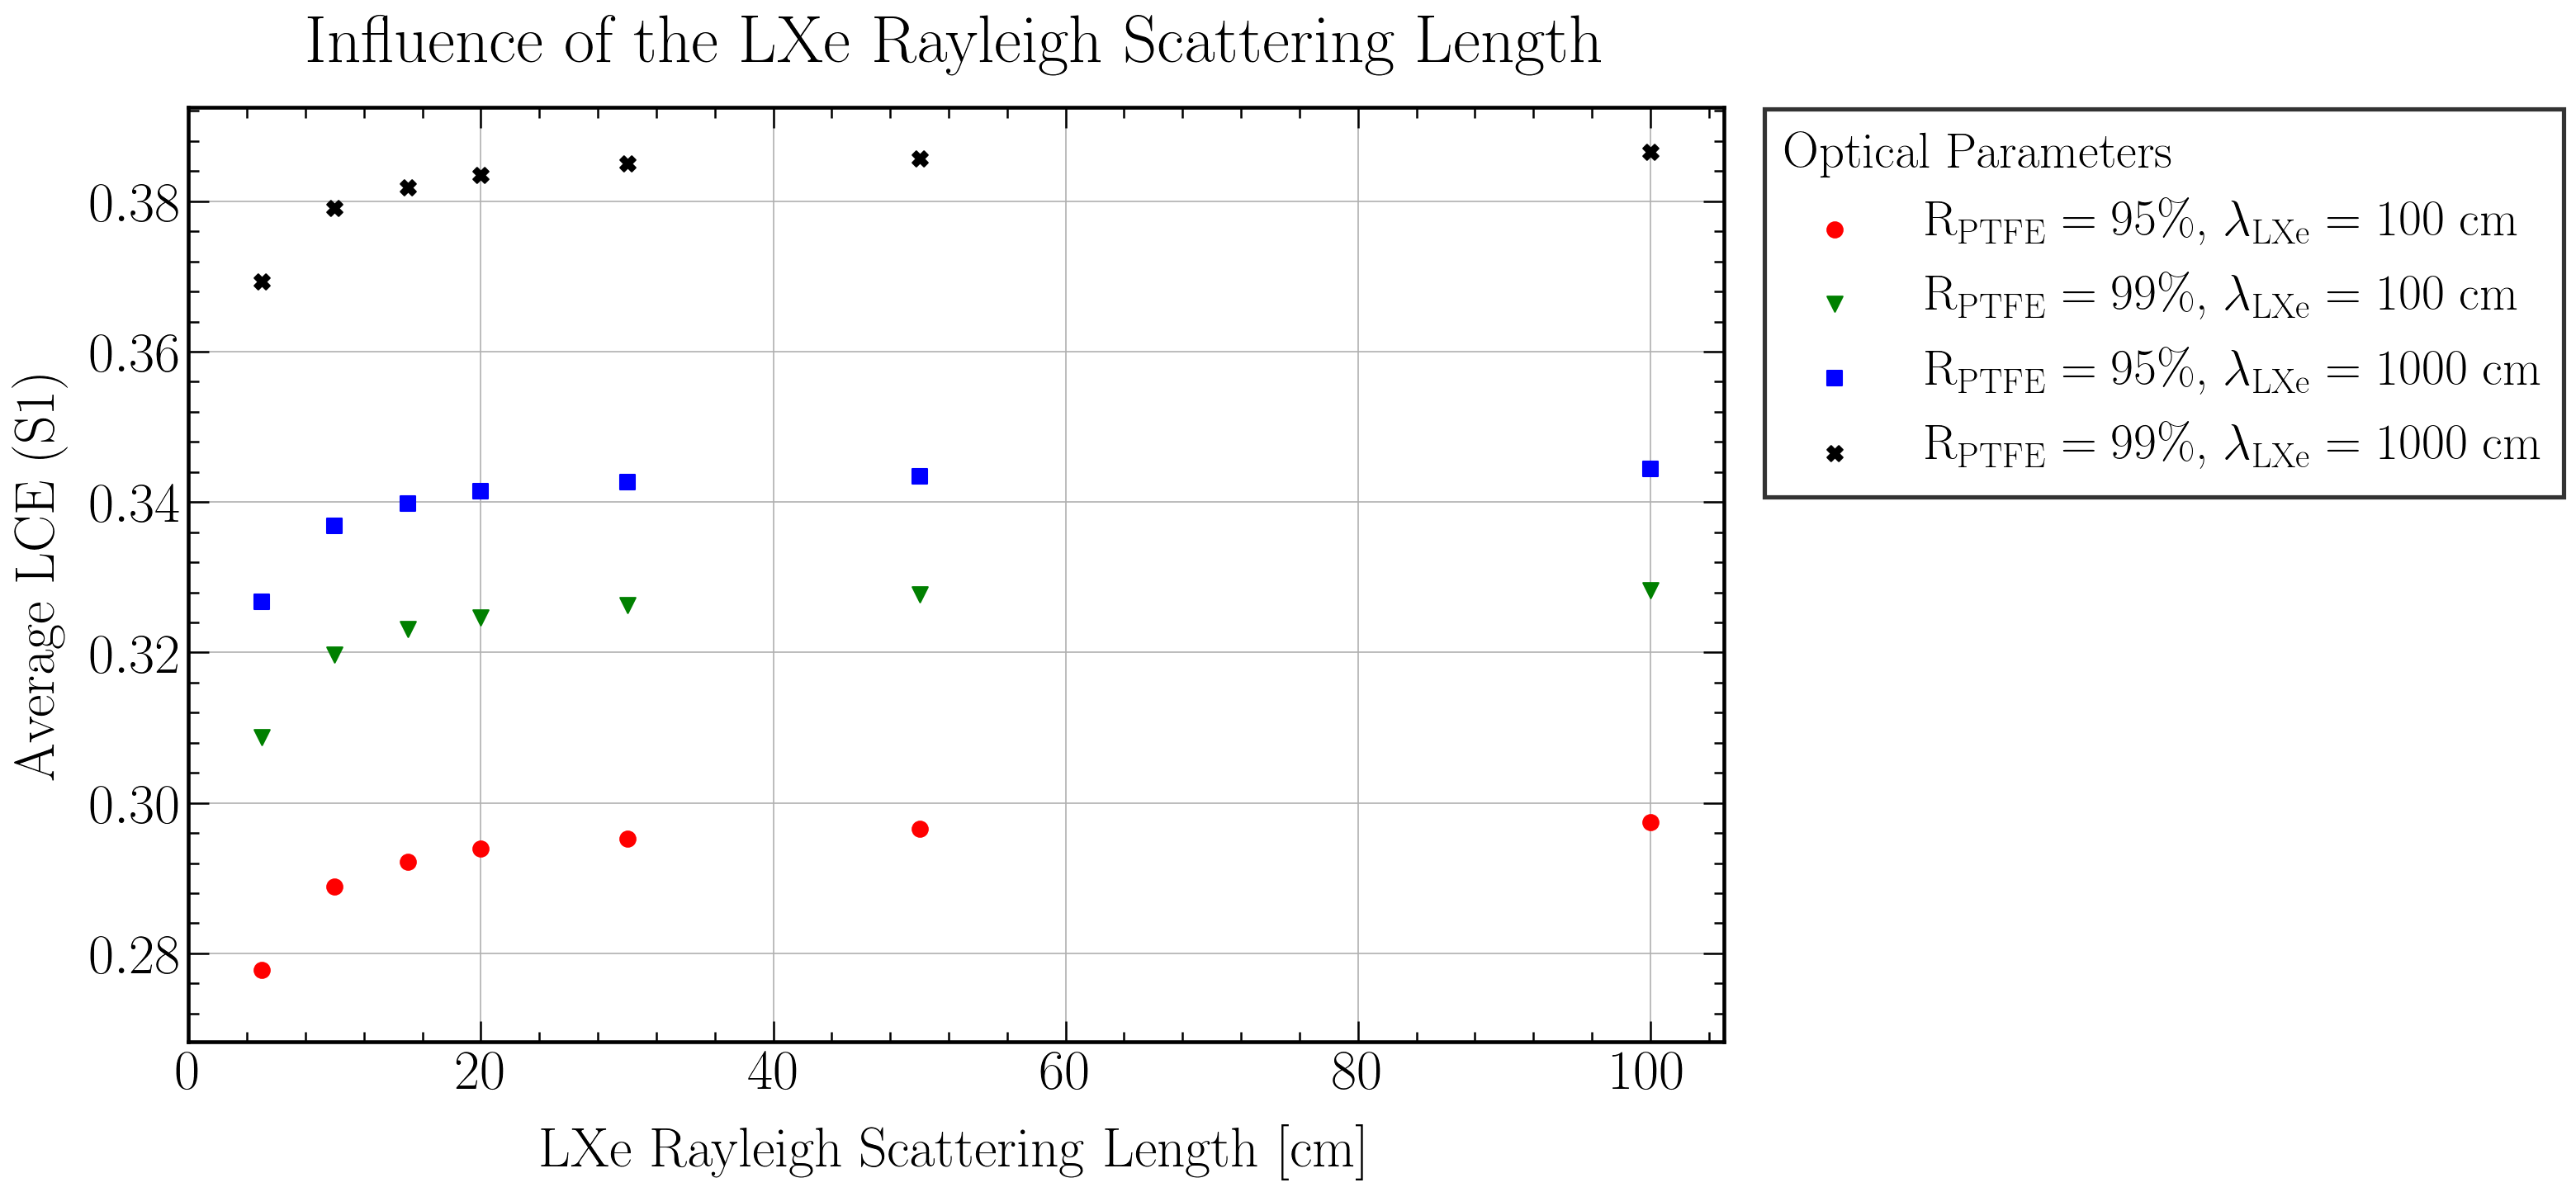

In [7]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE.png", bbox_inches='tight')
plt.show()

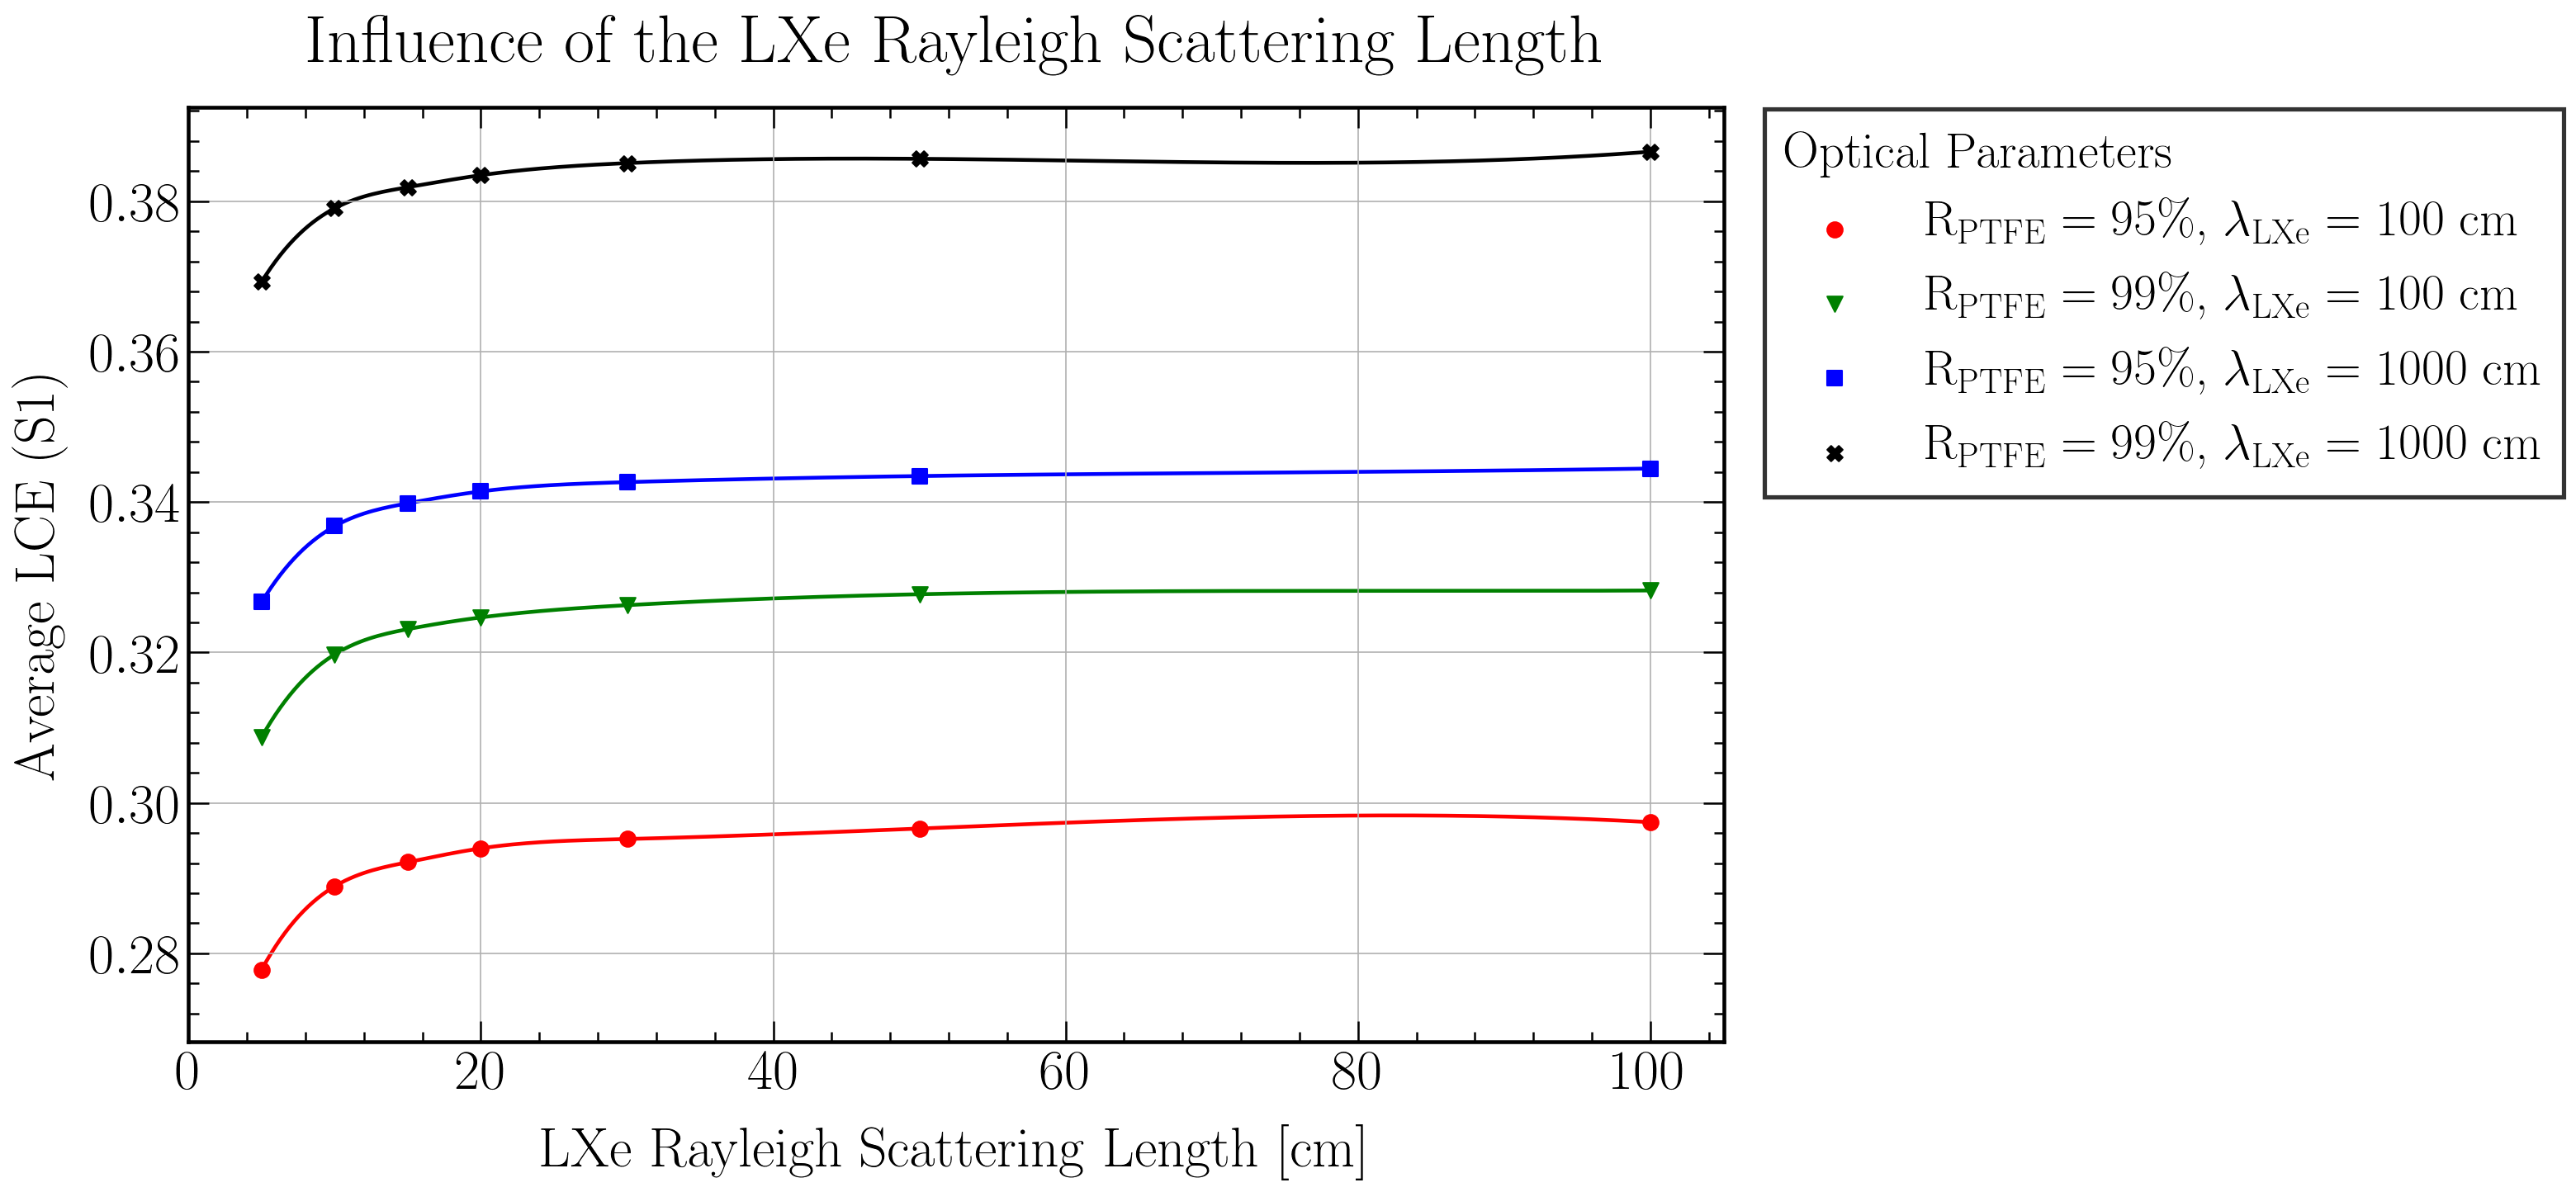

In [8]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE_spline.png", bbox_inches='tight')
plt.show()

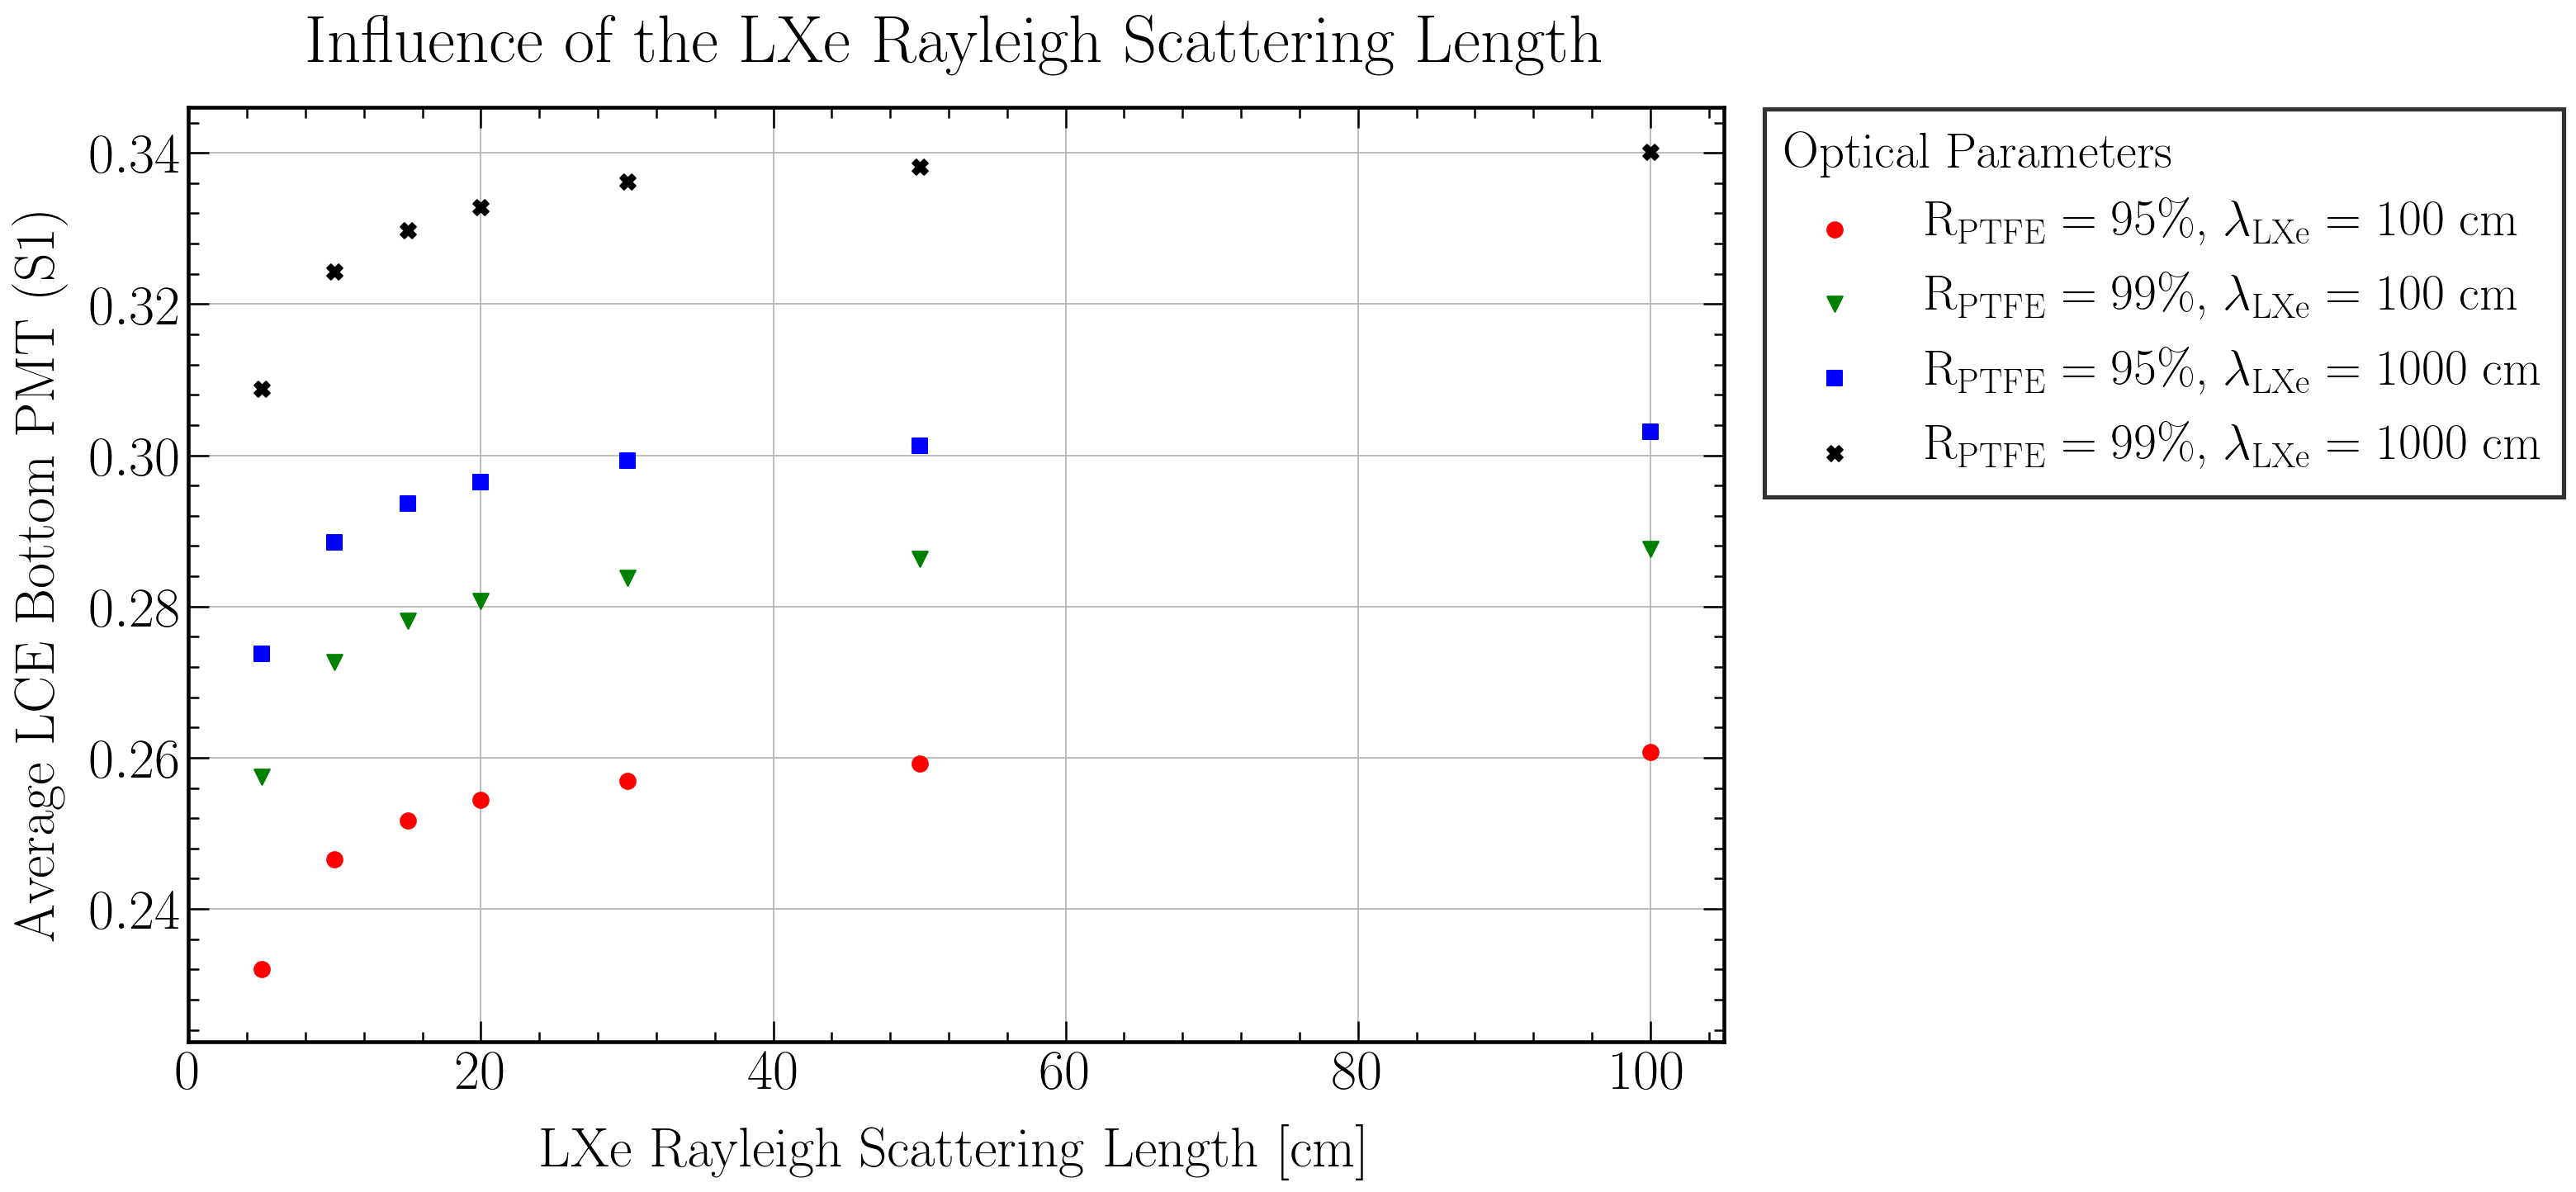

In [9]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE_Bottom.png", bbox_inches='tight')
plt.show()

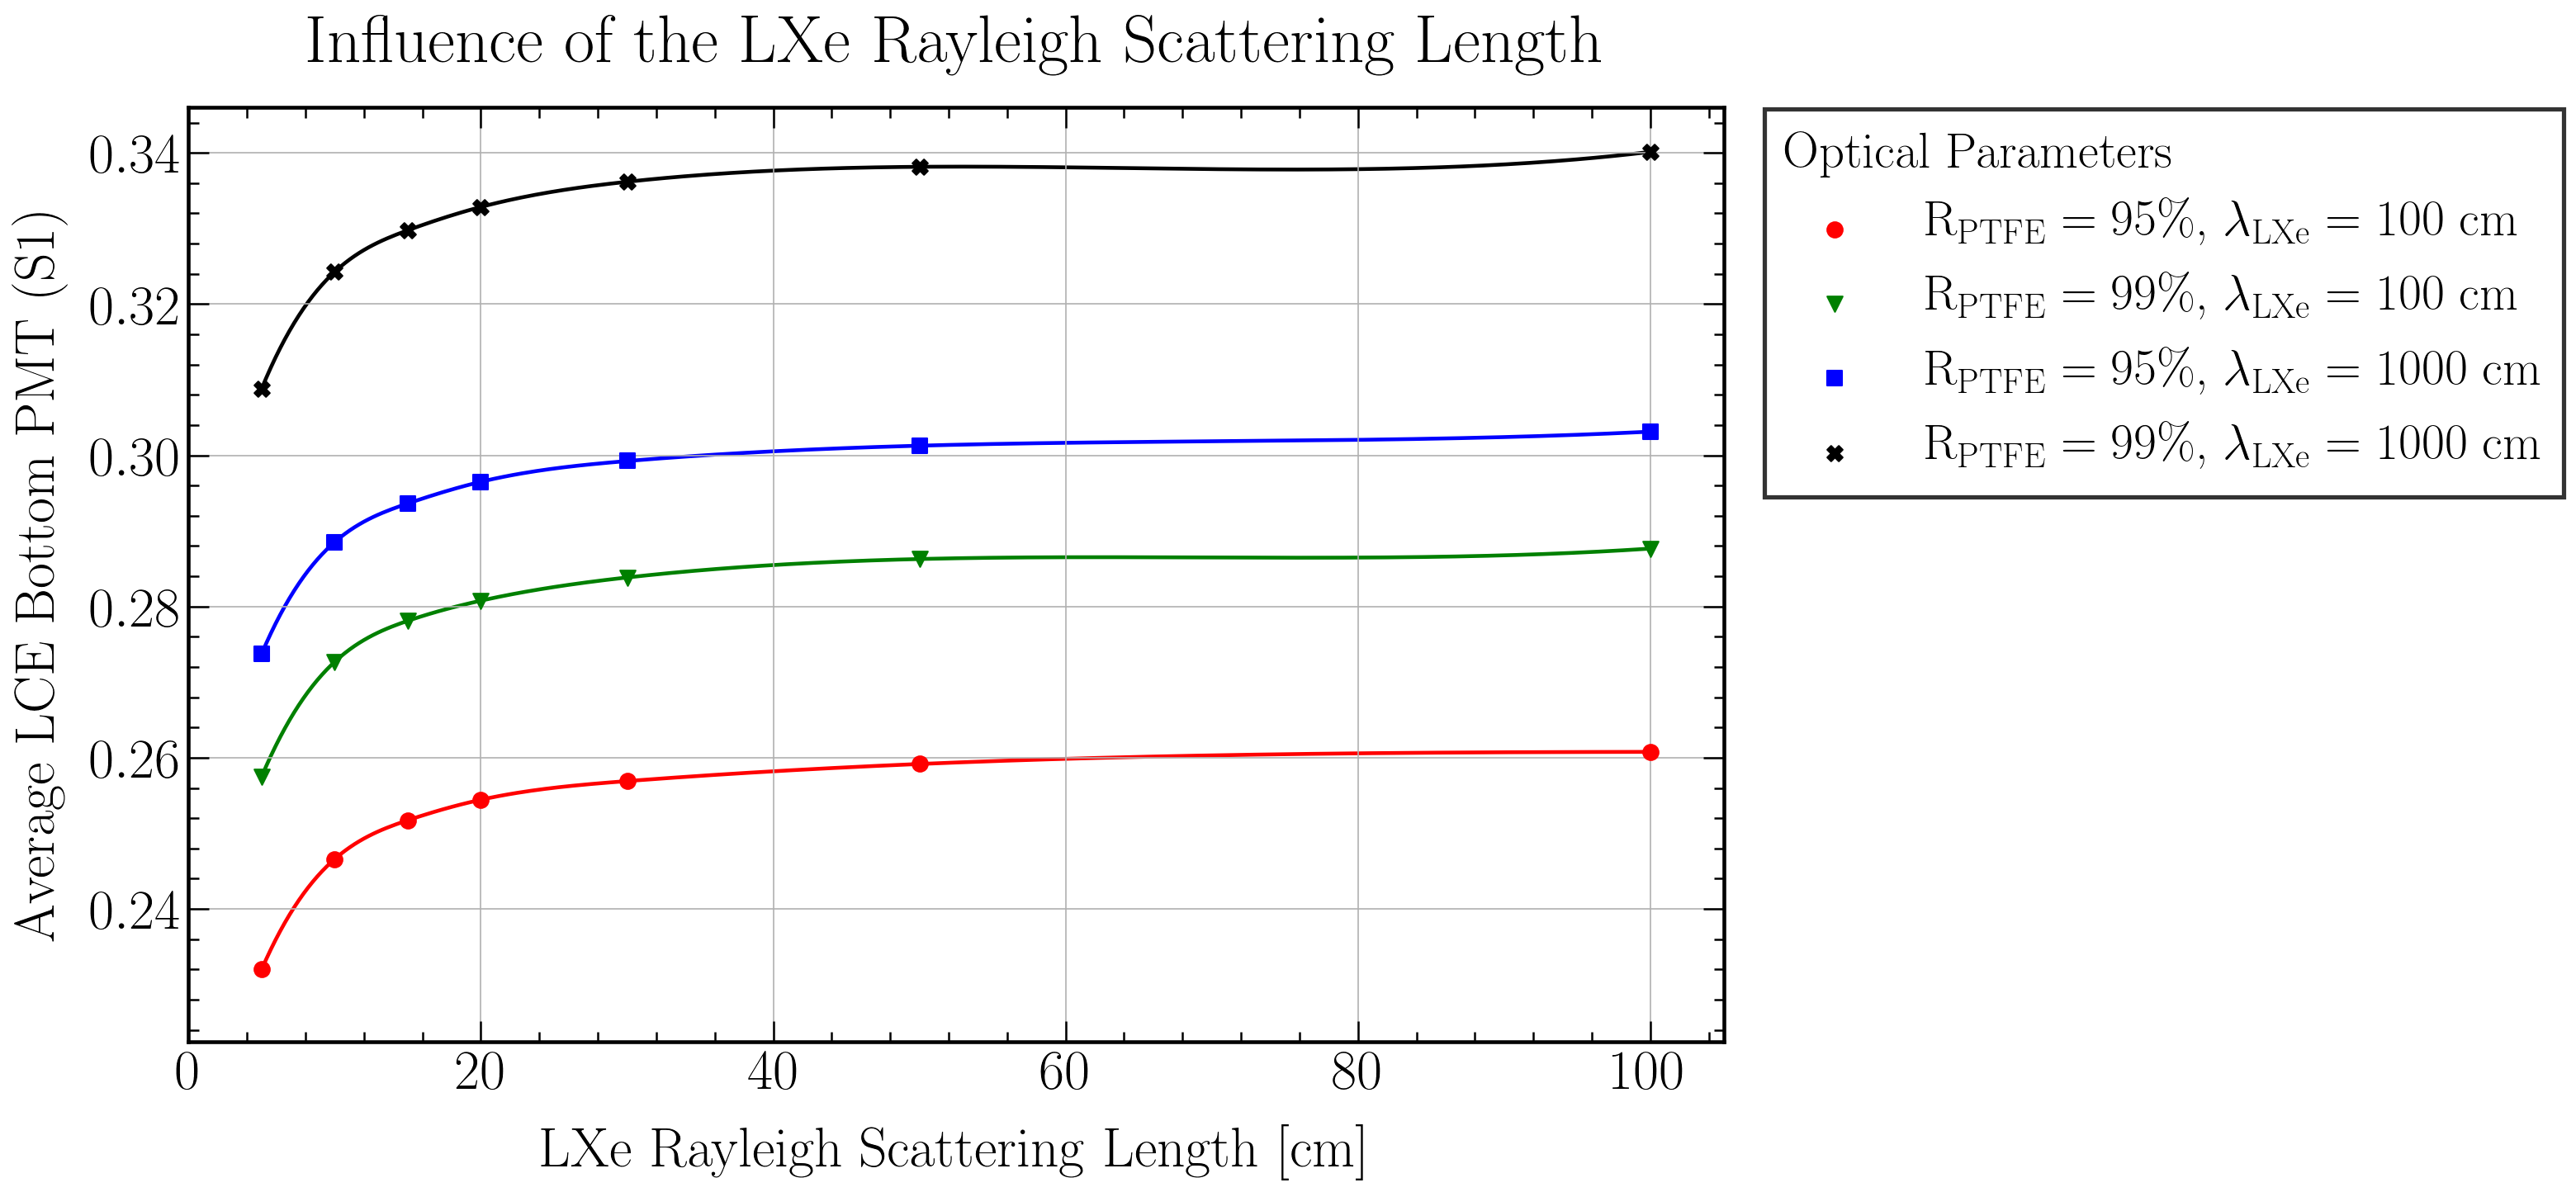

In [10]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE_Bottom_spline.png", bbox_inches='tight')
plt.show()

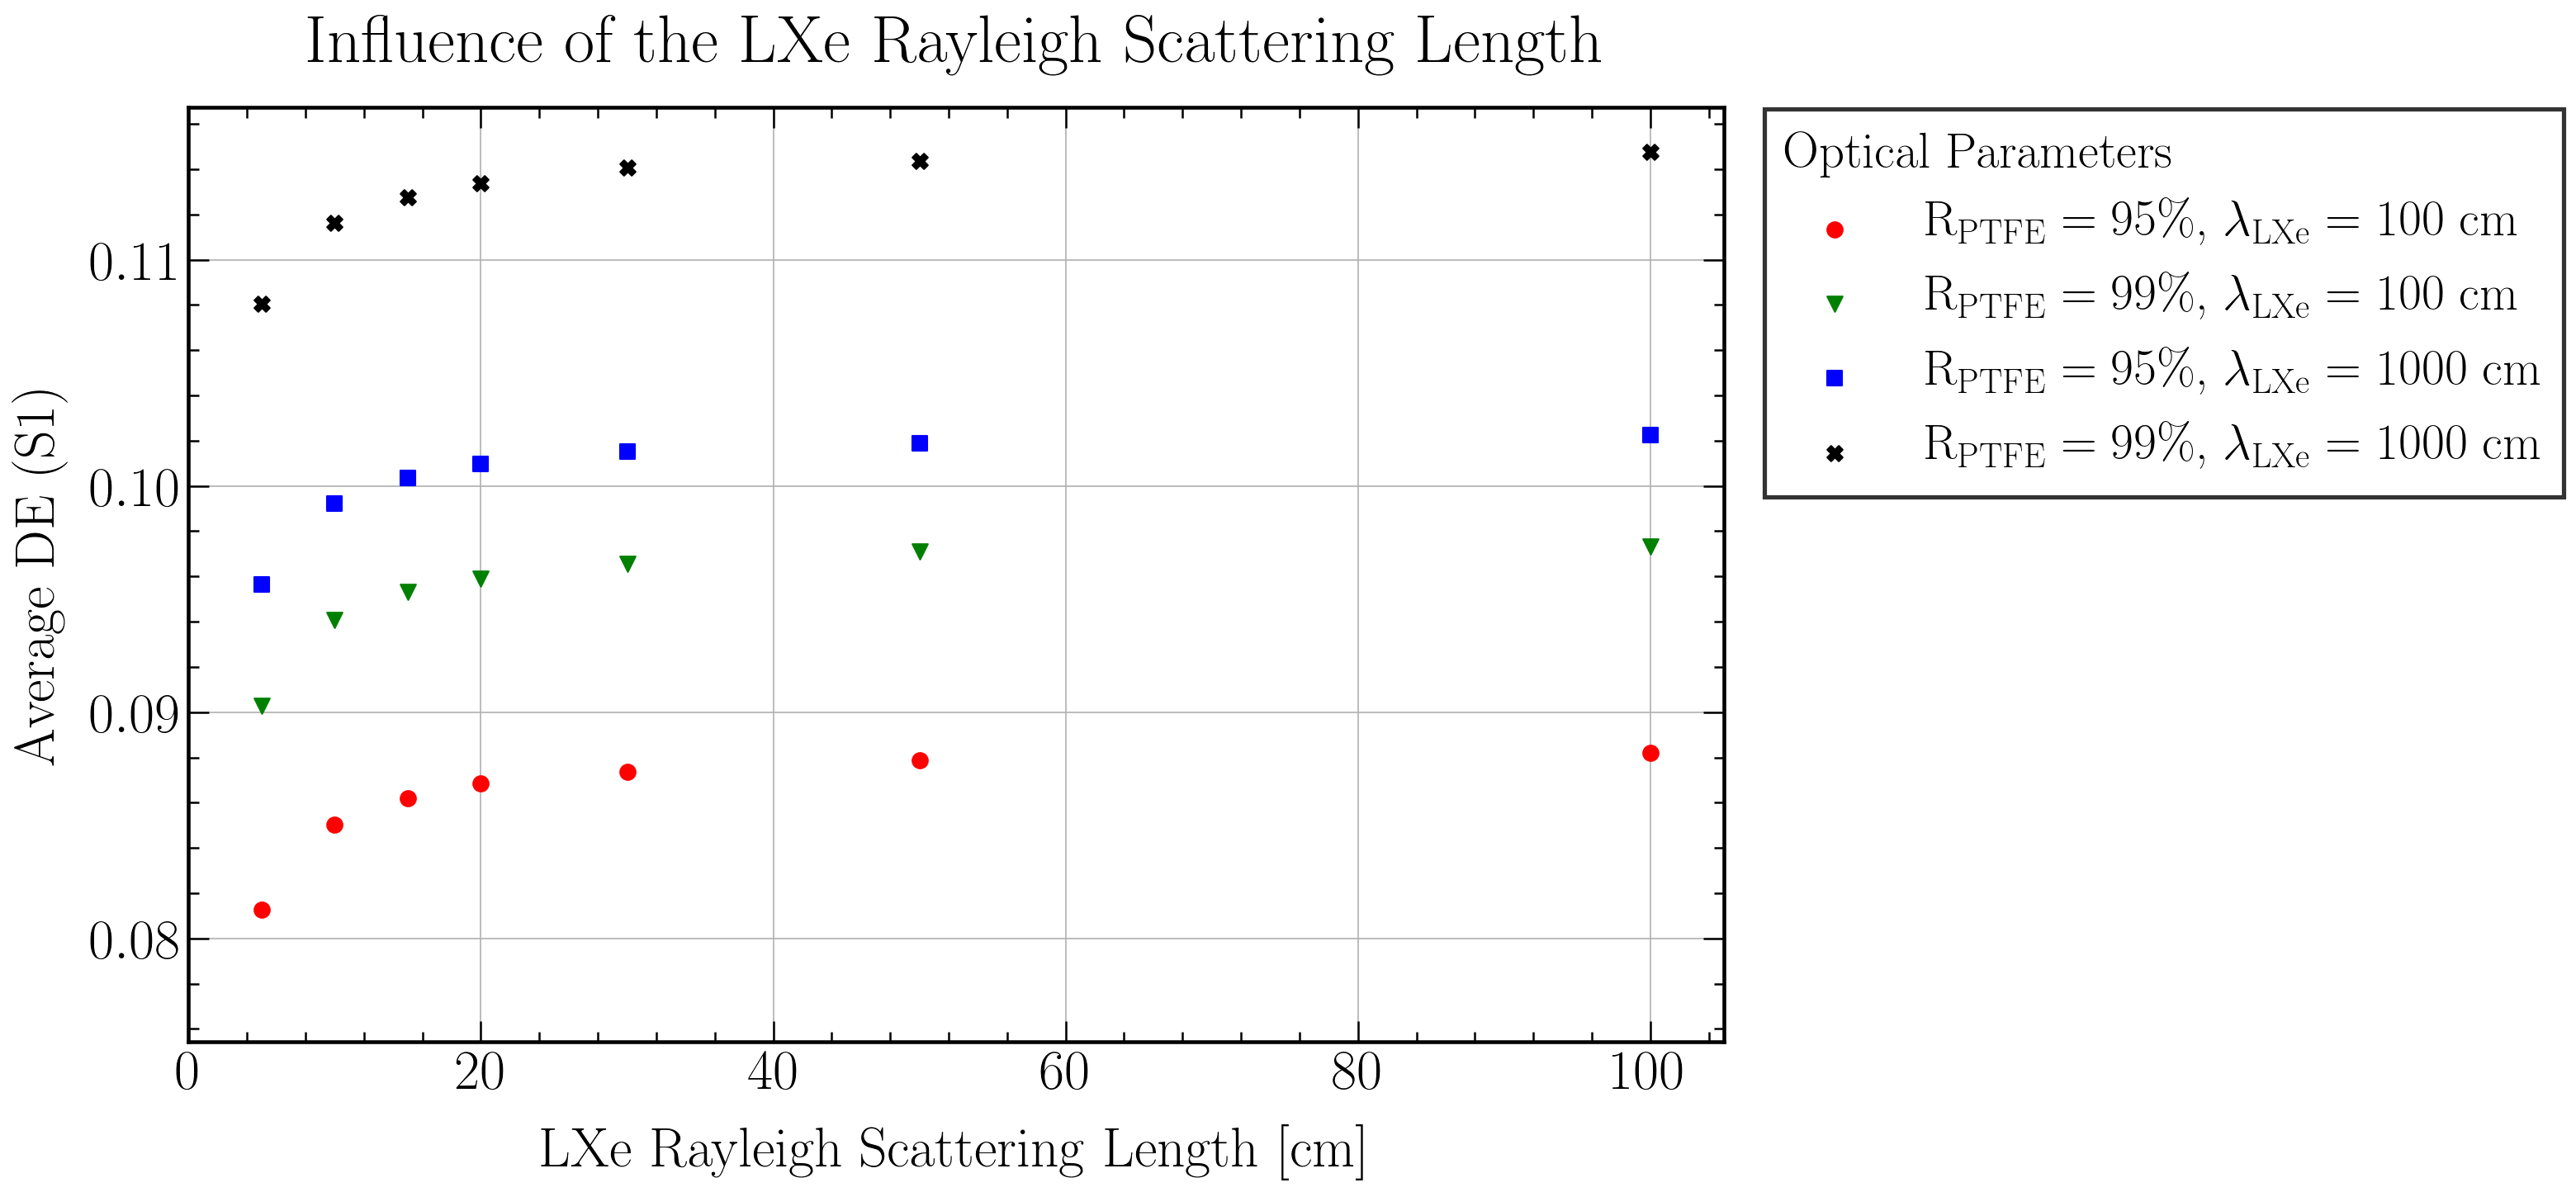

In [11]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE.png", bbox_inches='tight')
plt.show()

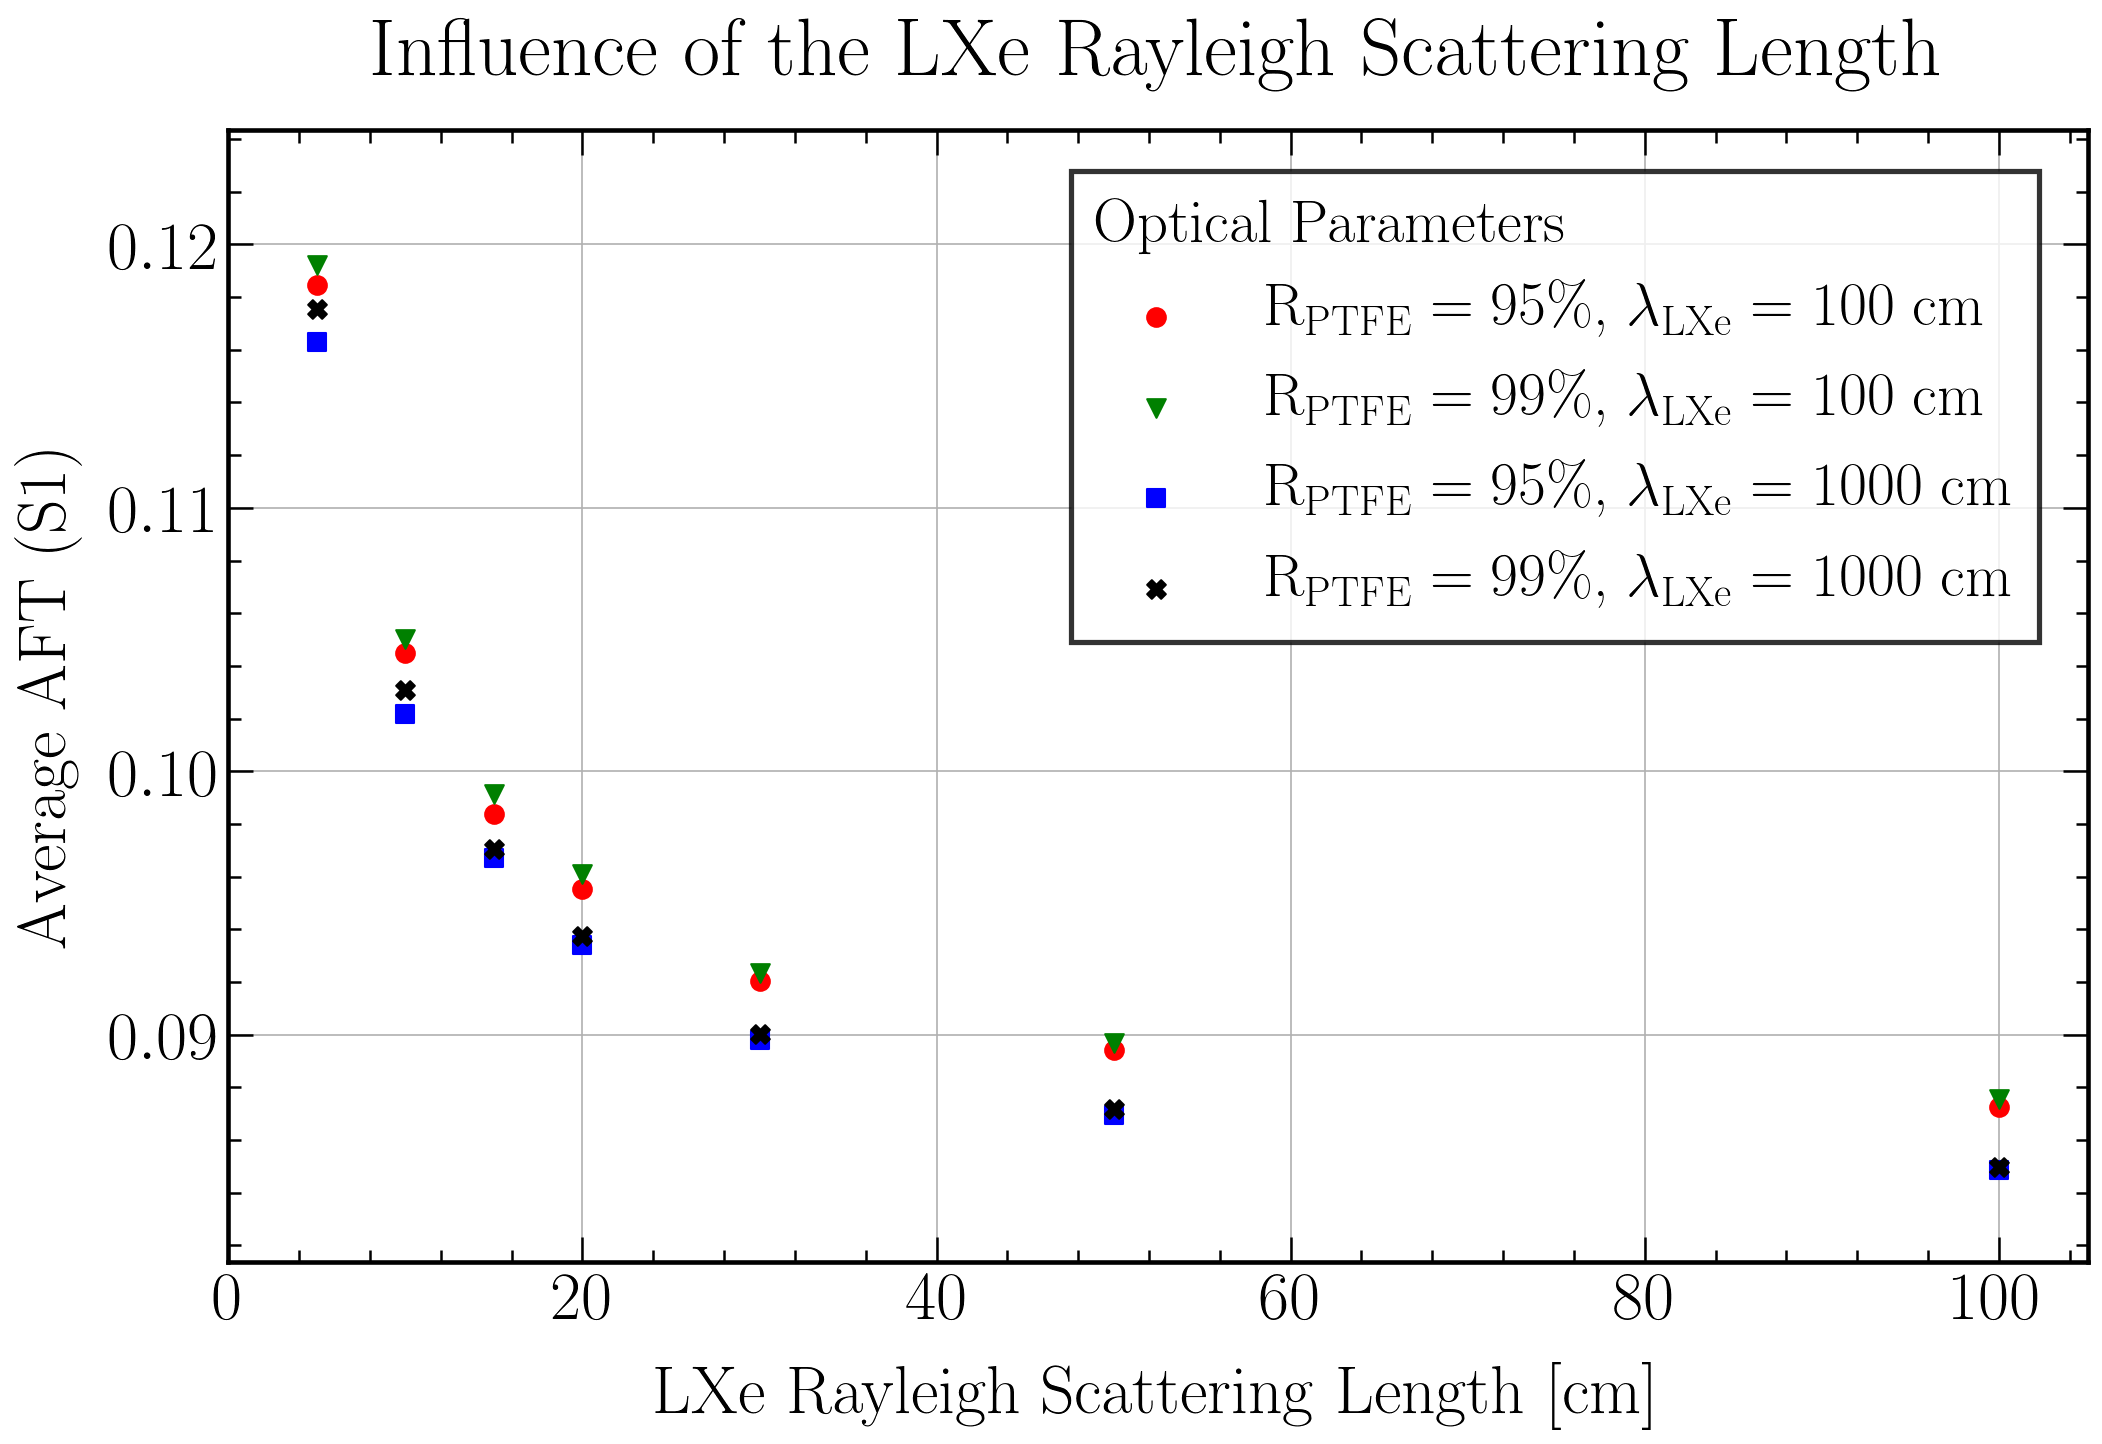

In [12]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_AFT.png")
plt.show()

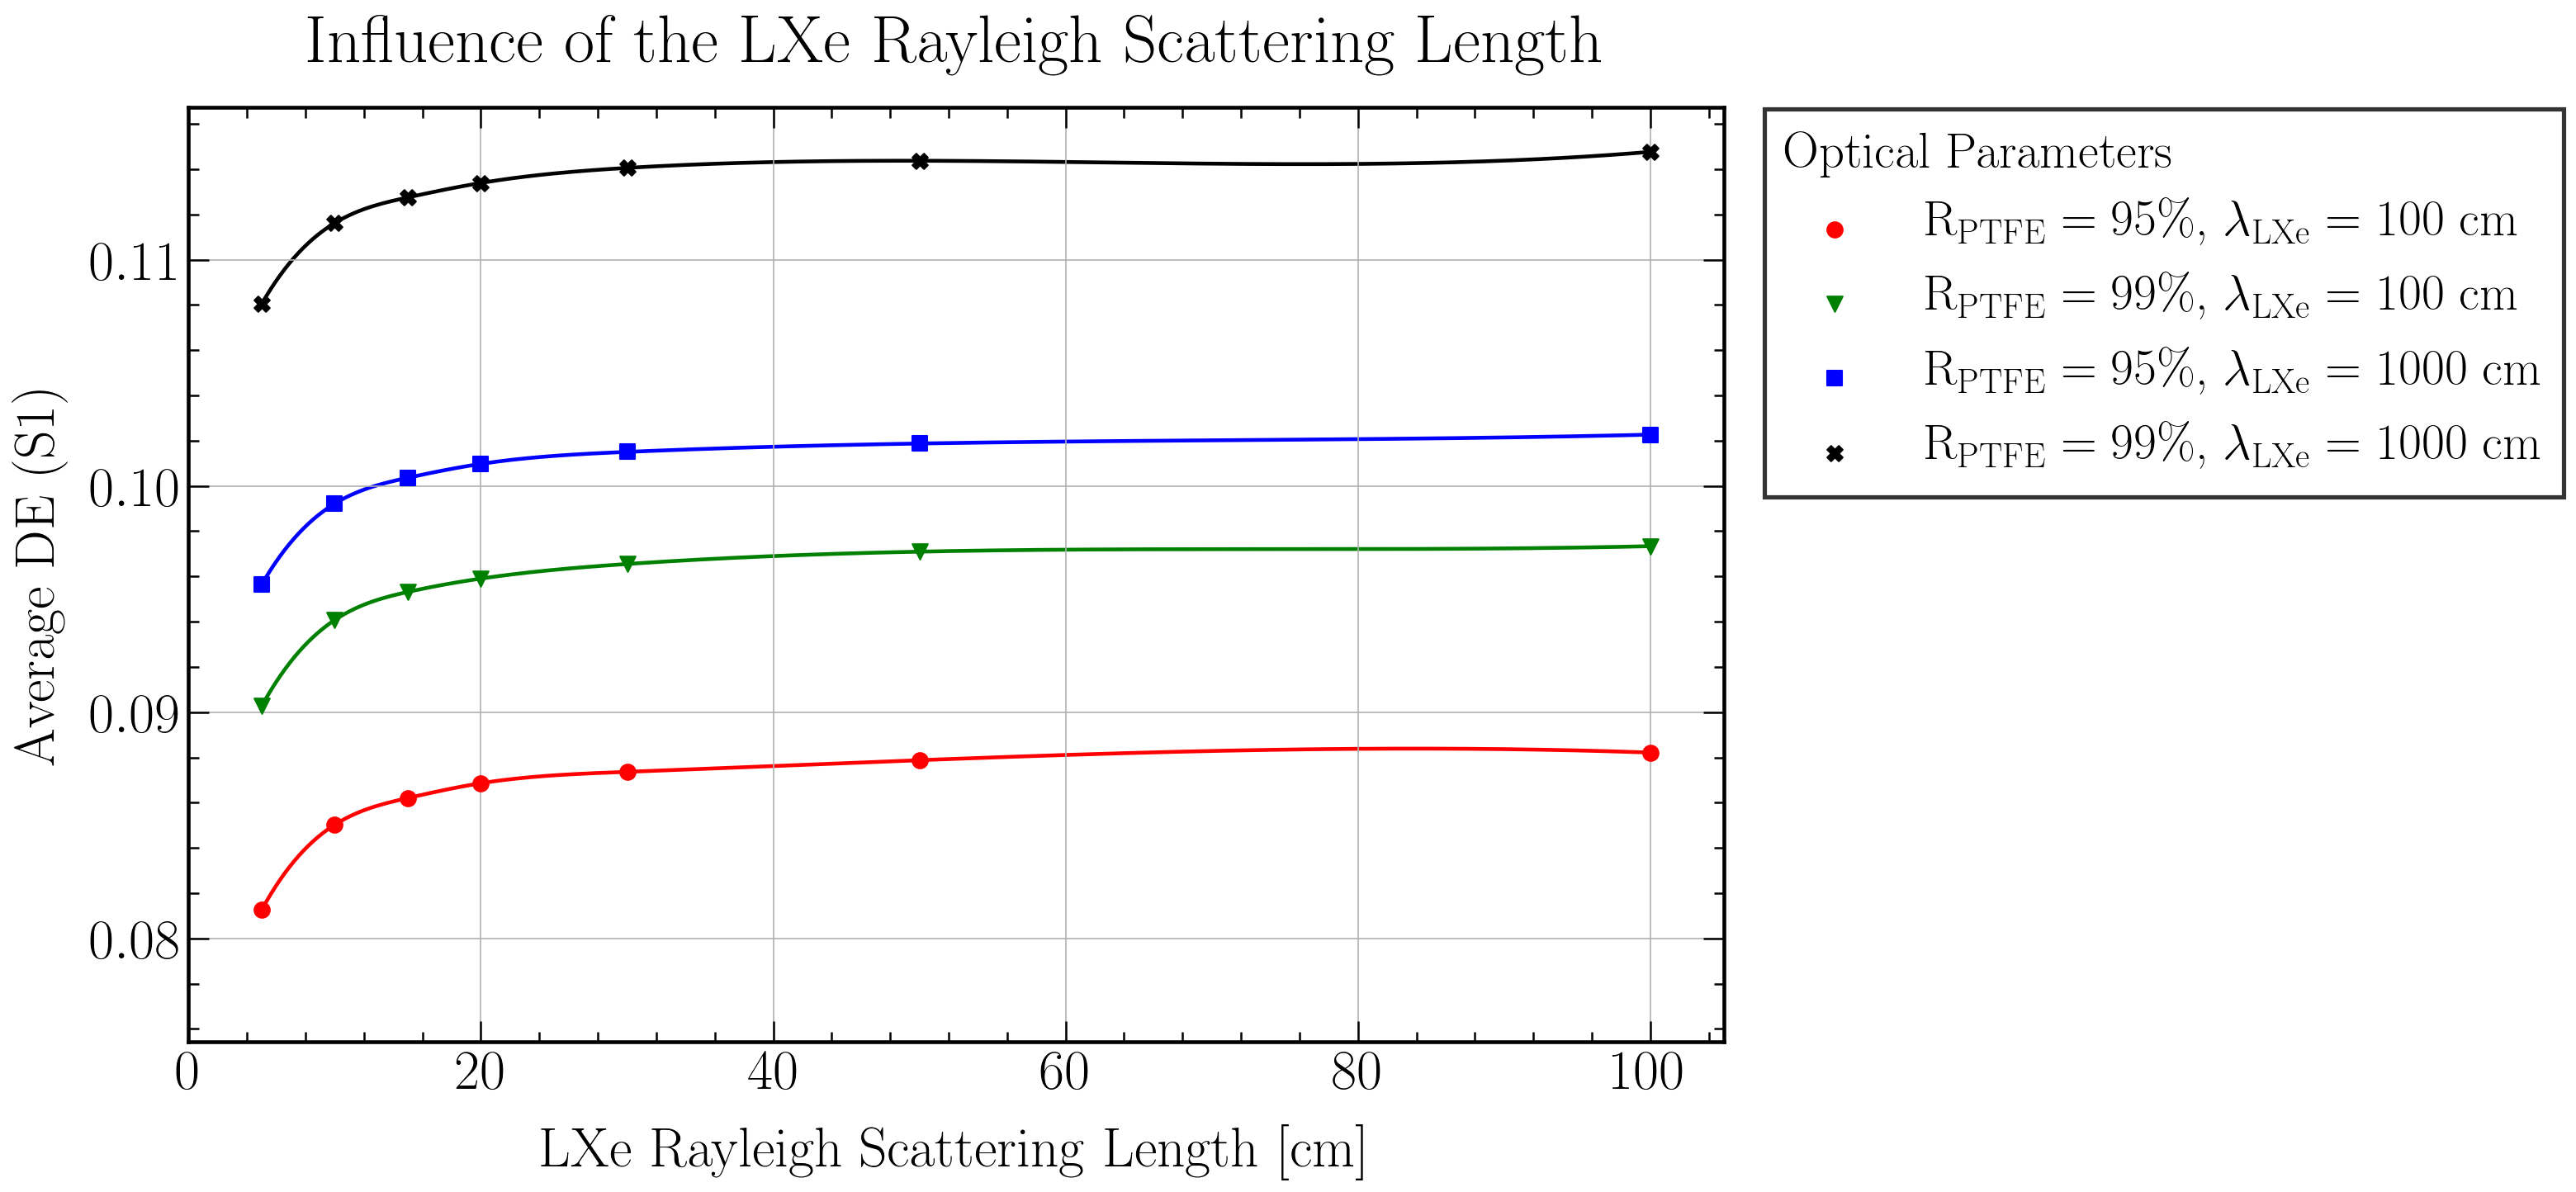

In [13]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_spline.png", bbox_inches='tight')
plt.show()

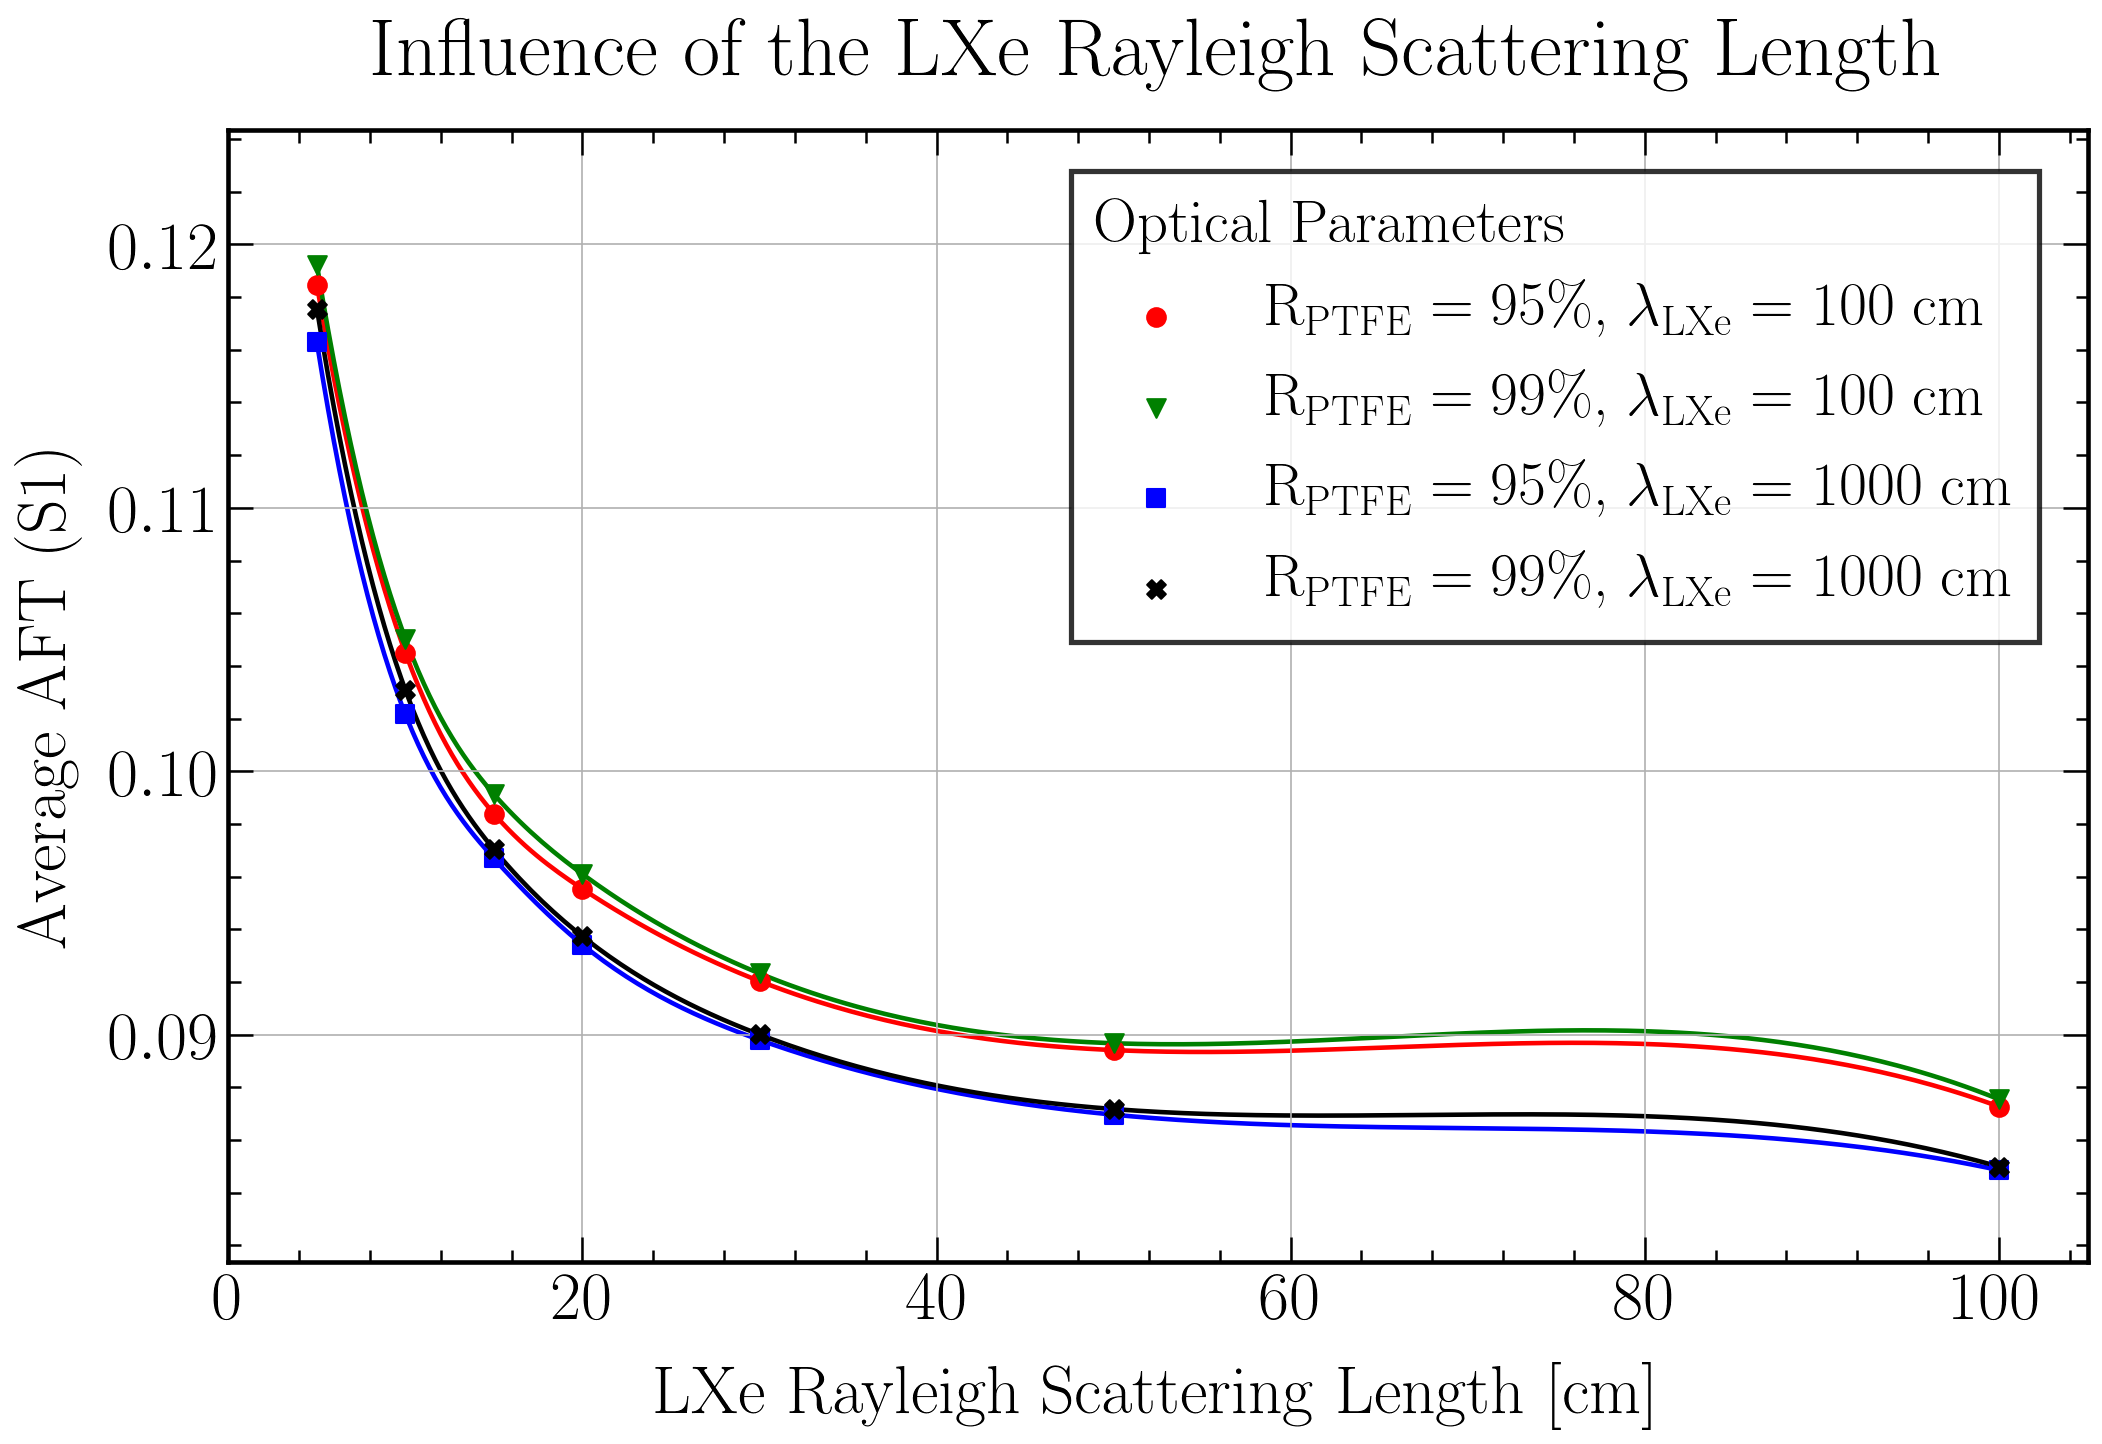

In [14]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)


plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_AFT_spline.png")
plt.show()

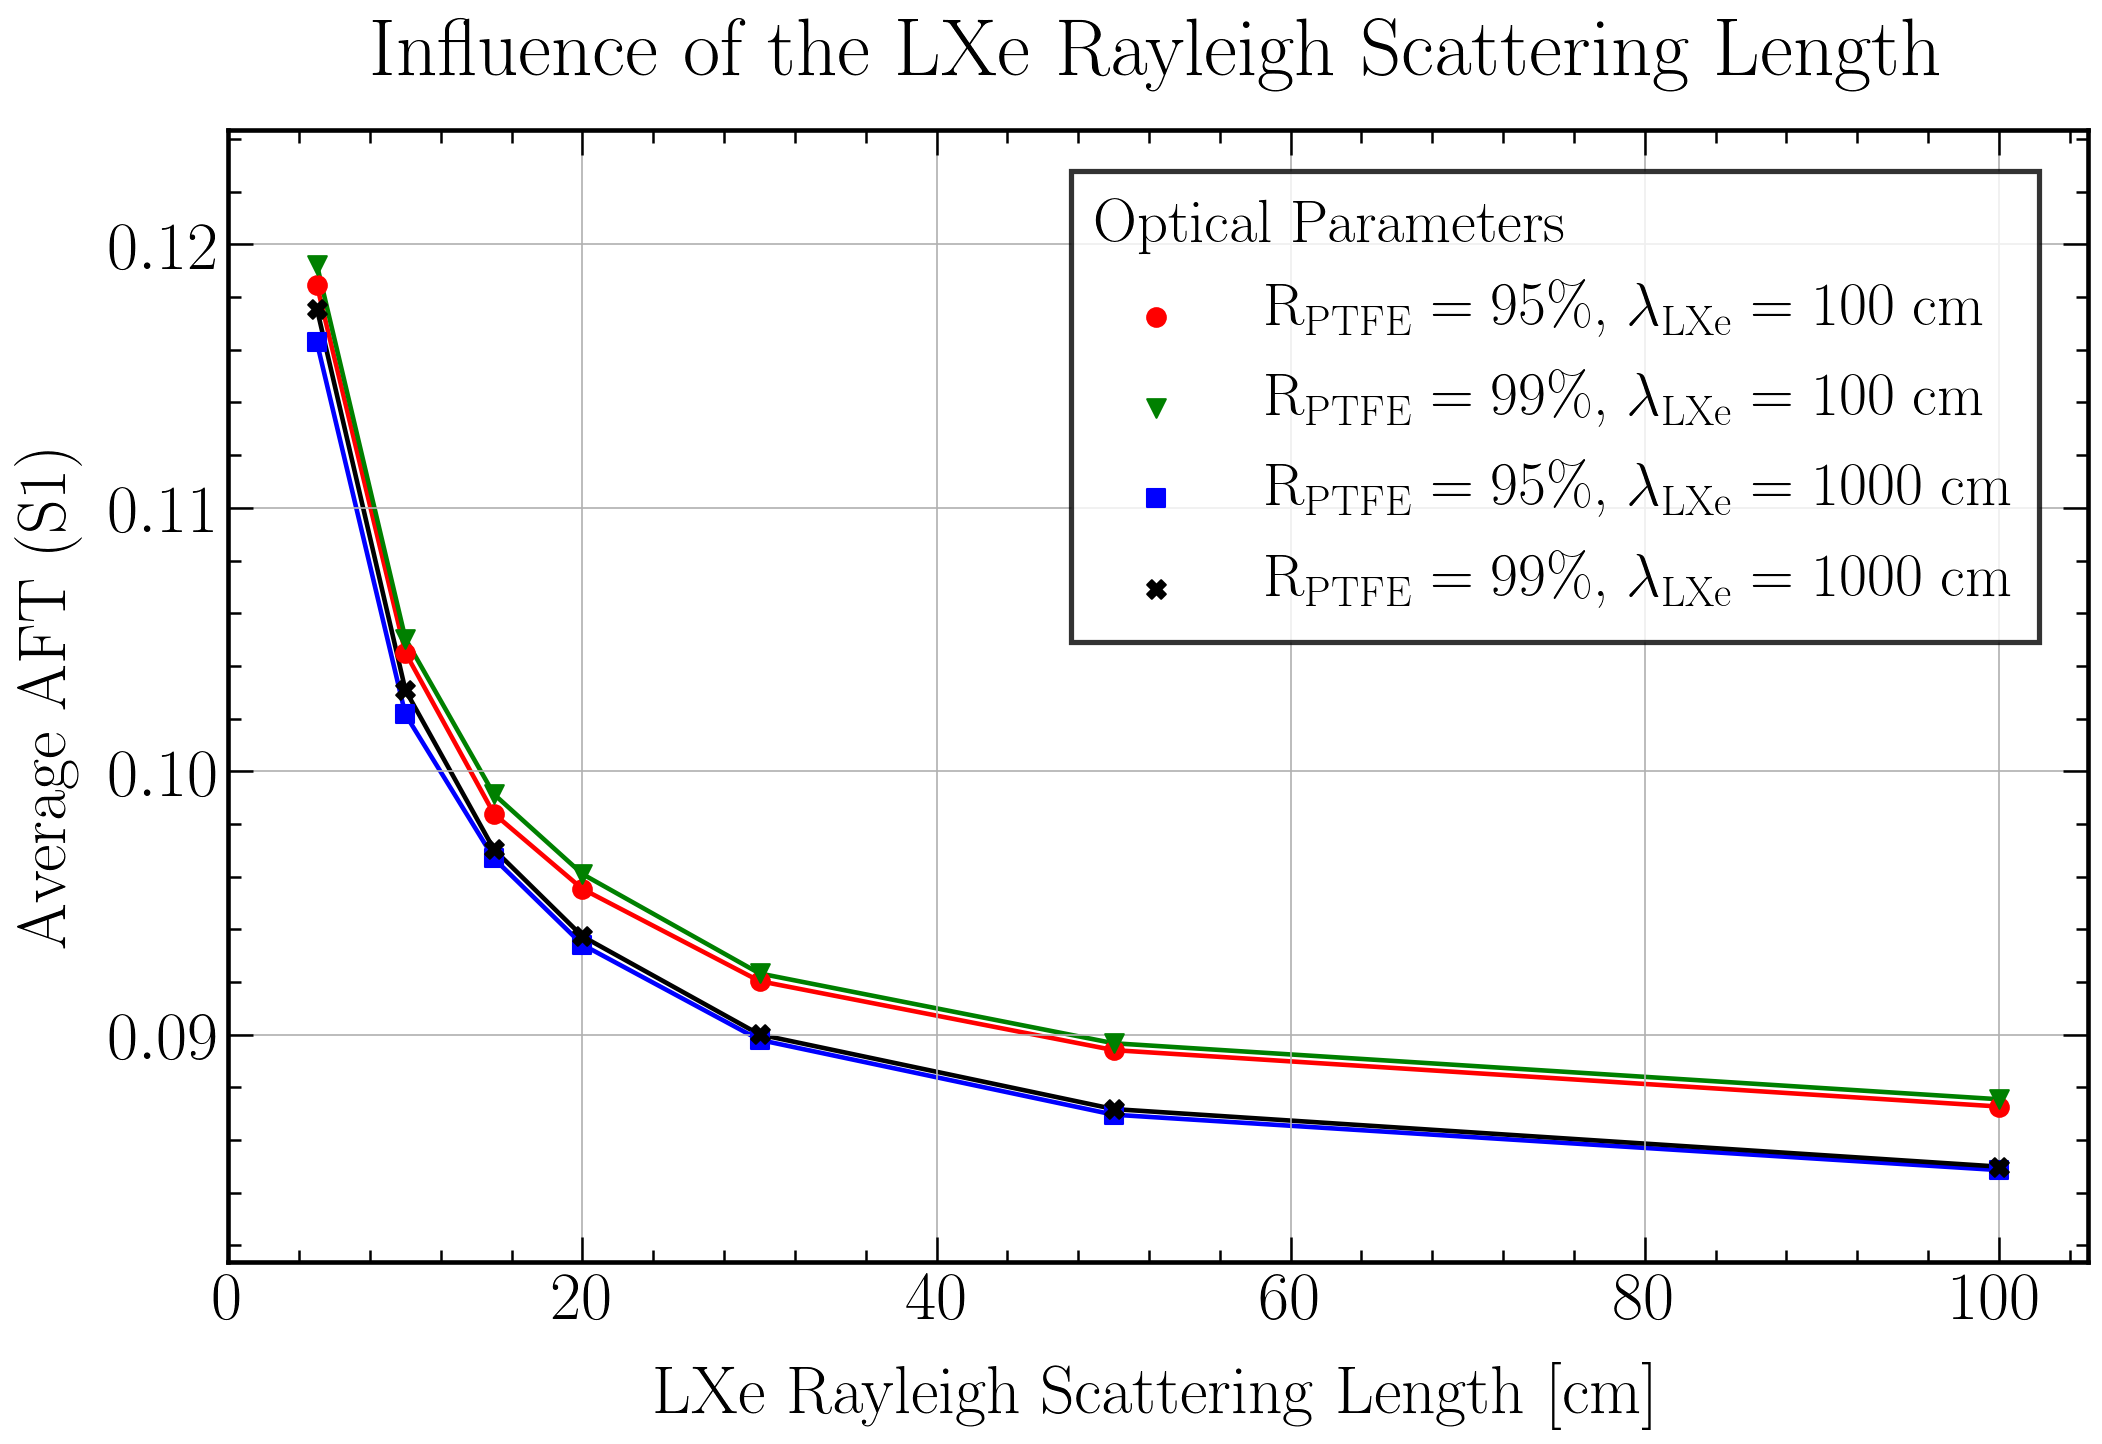

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'red', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'green', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'blue', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'black', zorder=0)


plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_AFT_spline2.png")
plt.show()

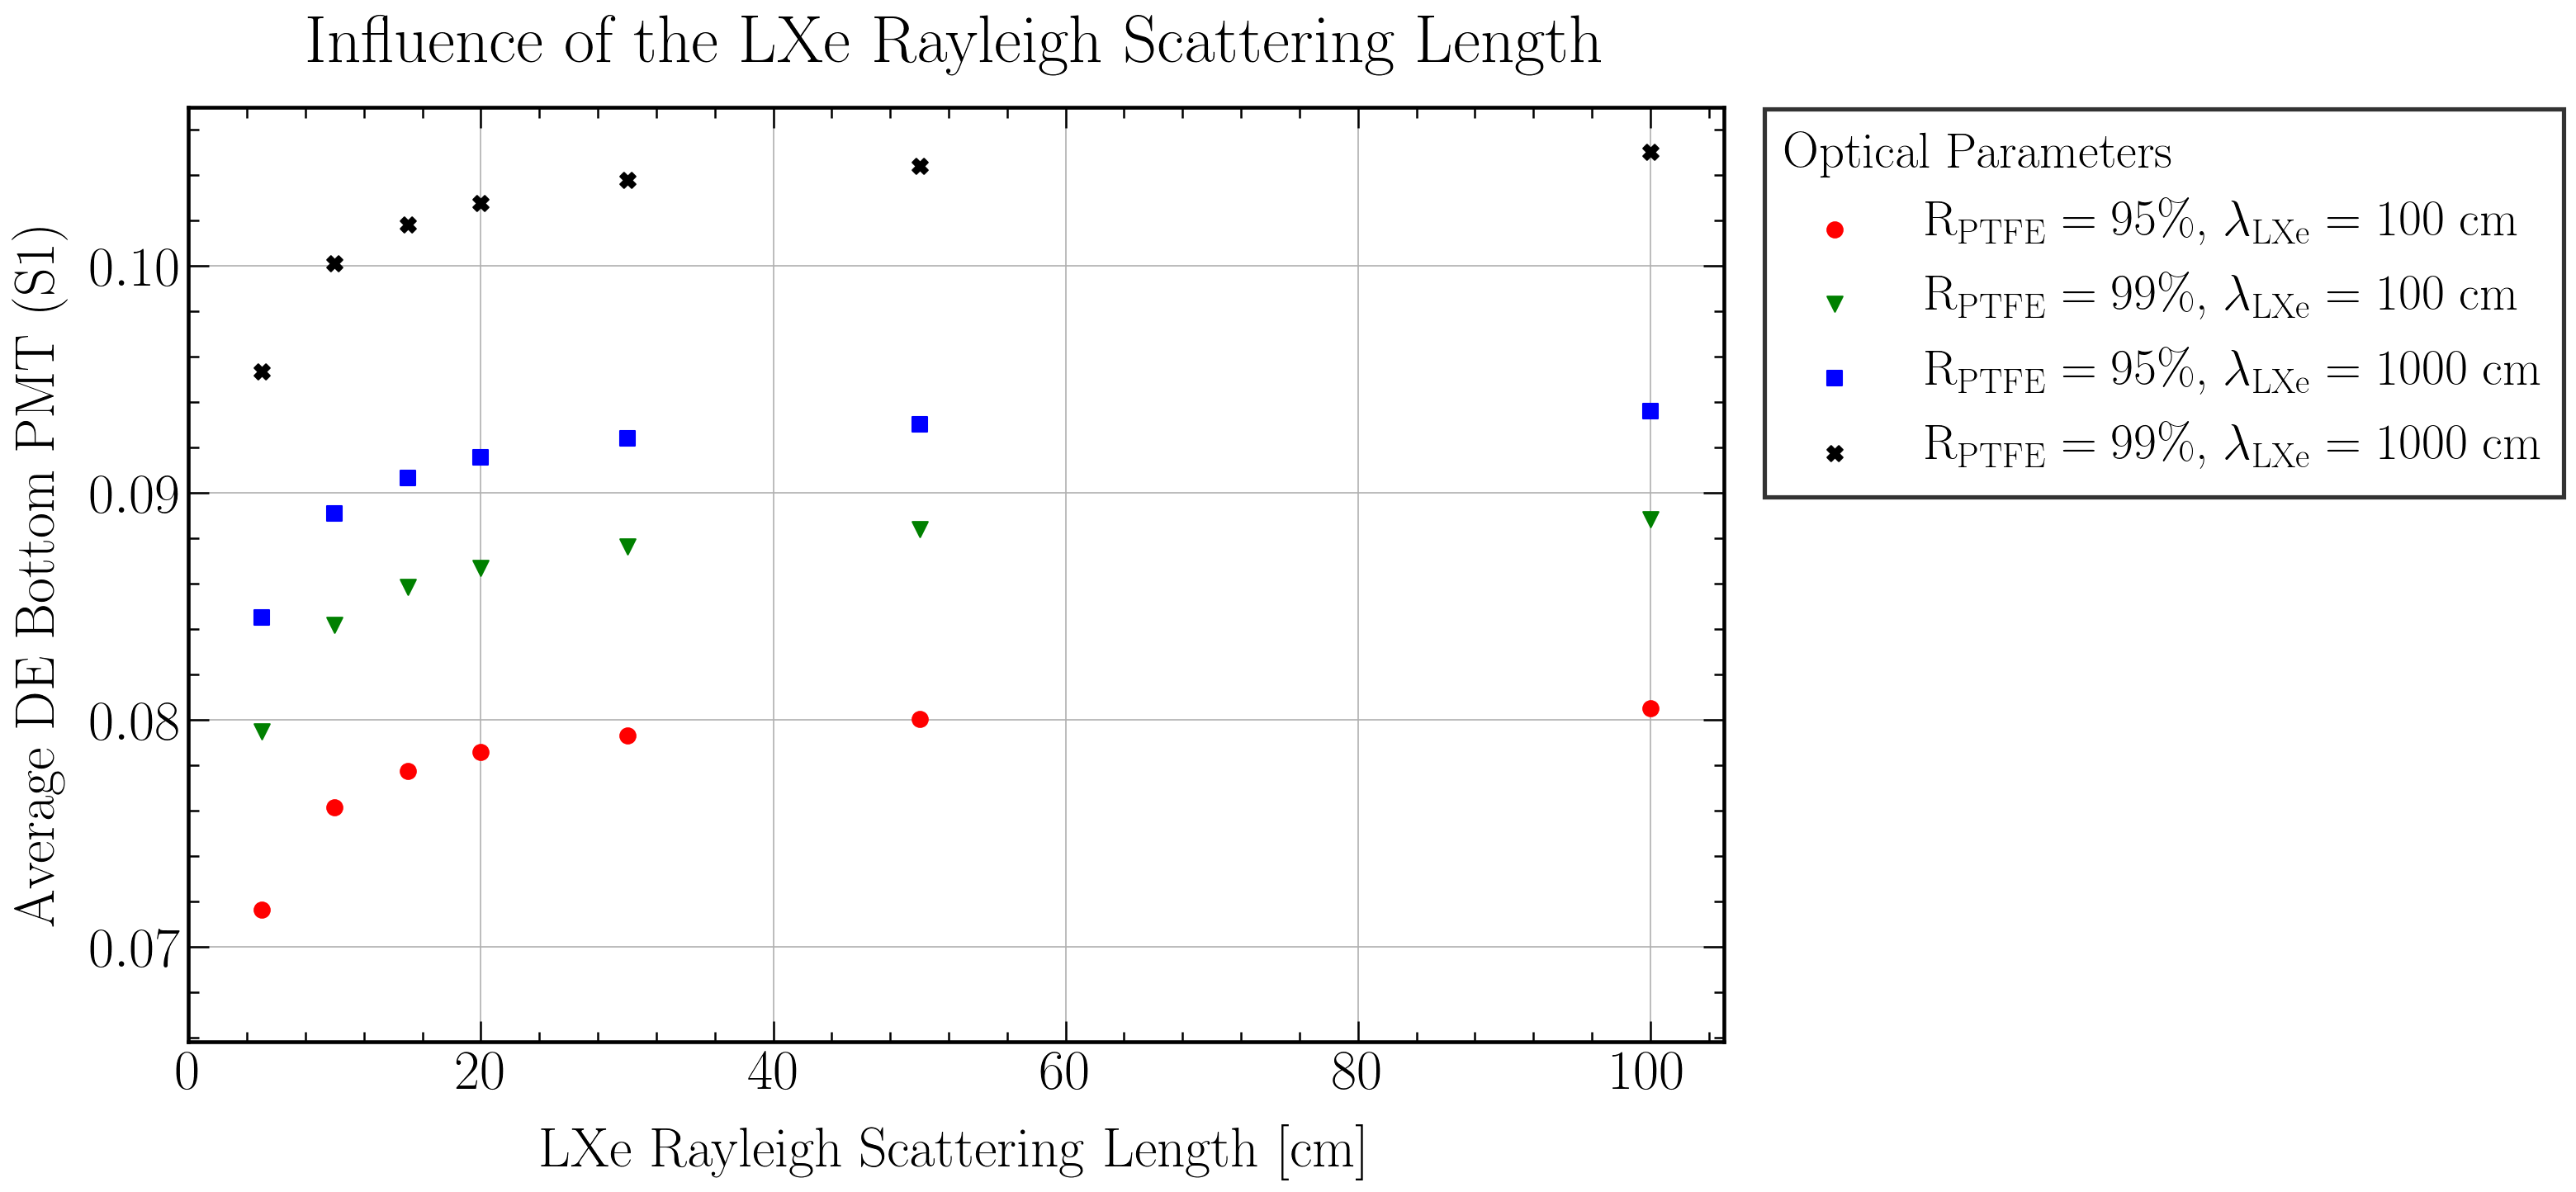

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_Bottom.png", bbox_inches='tight')
plt.show()

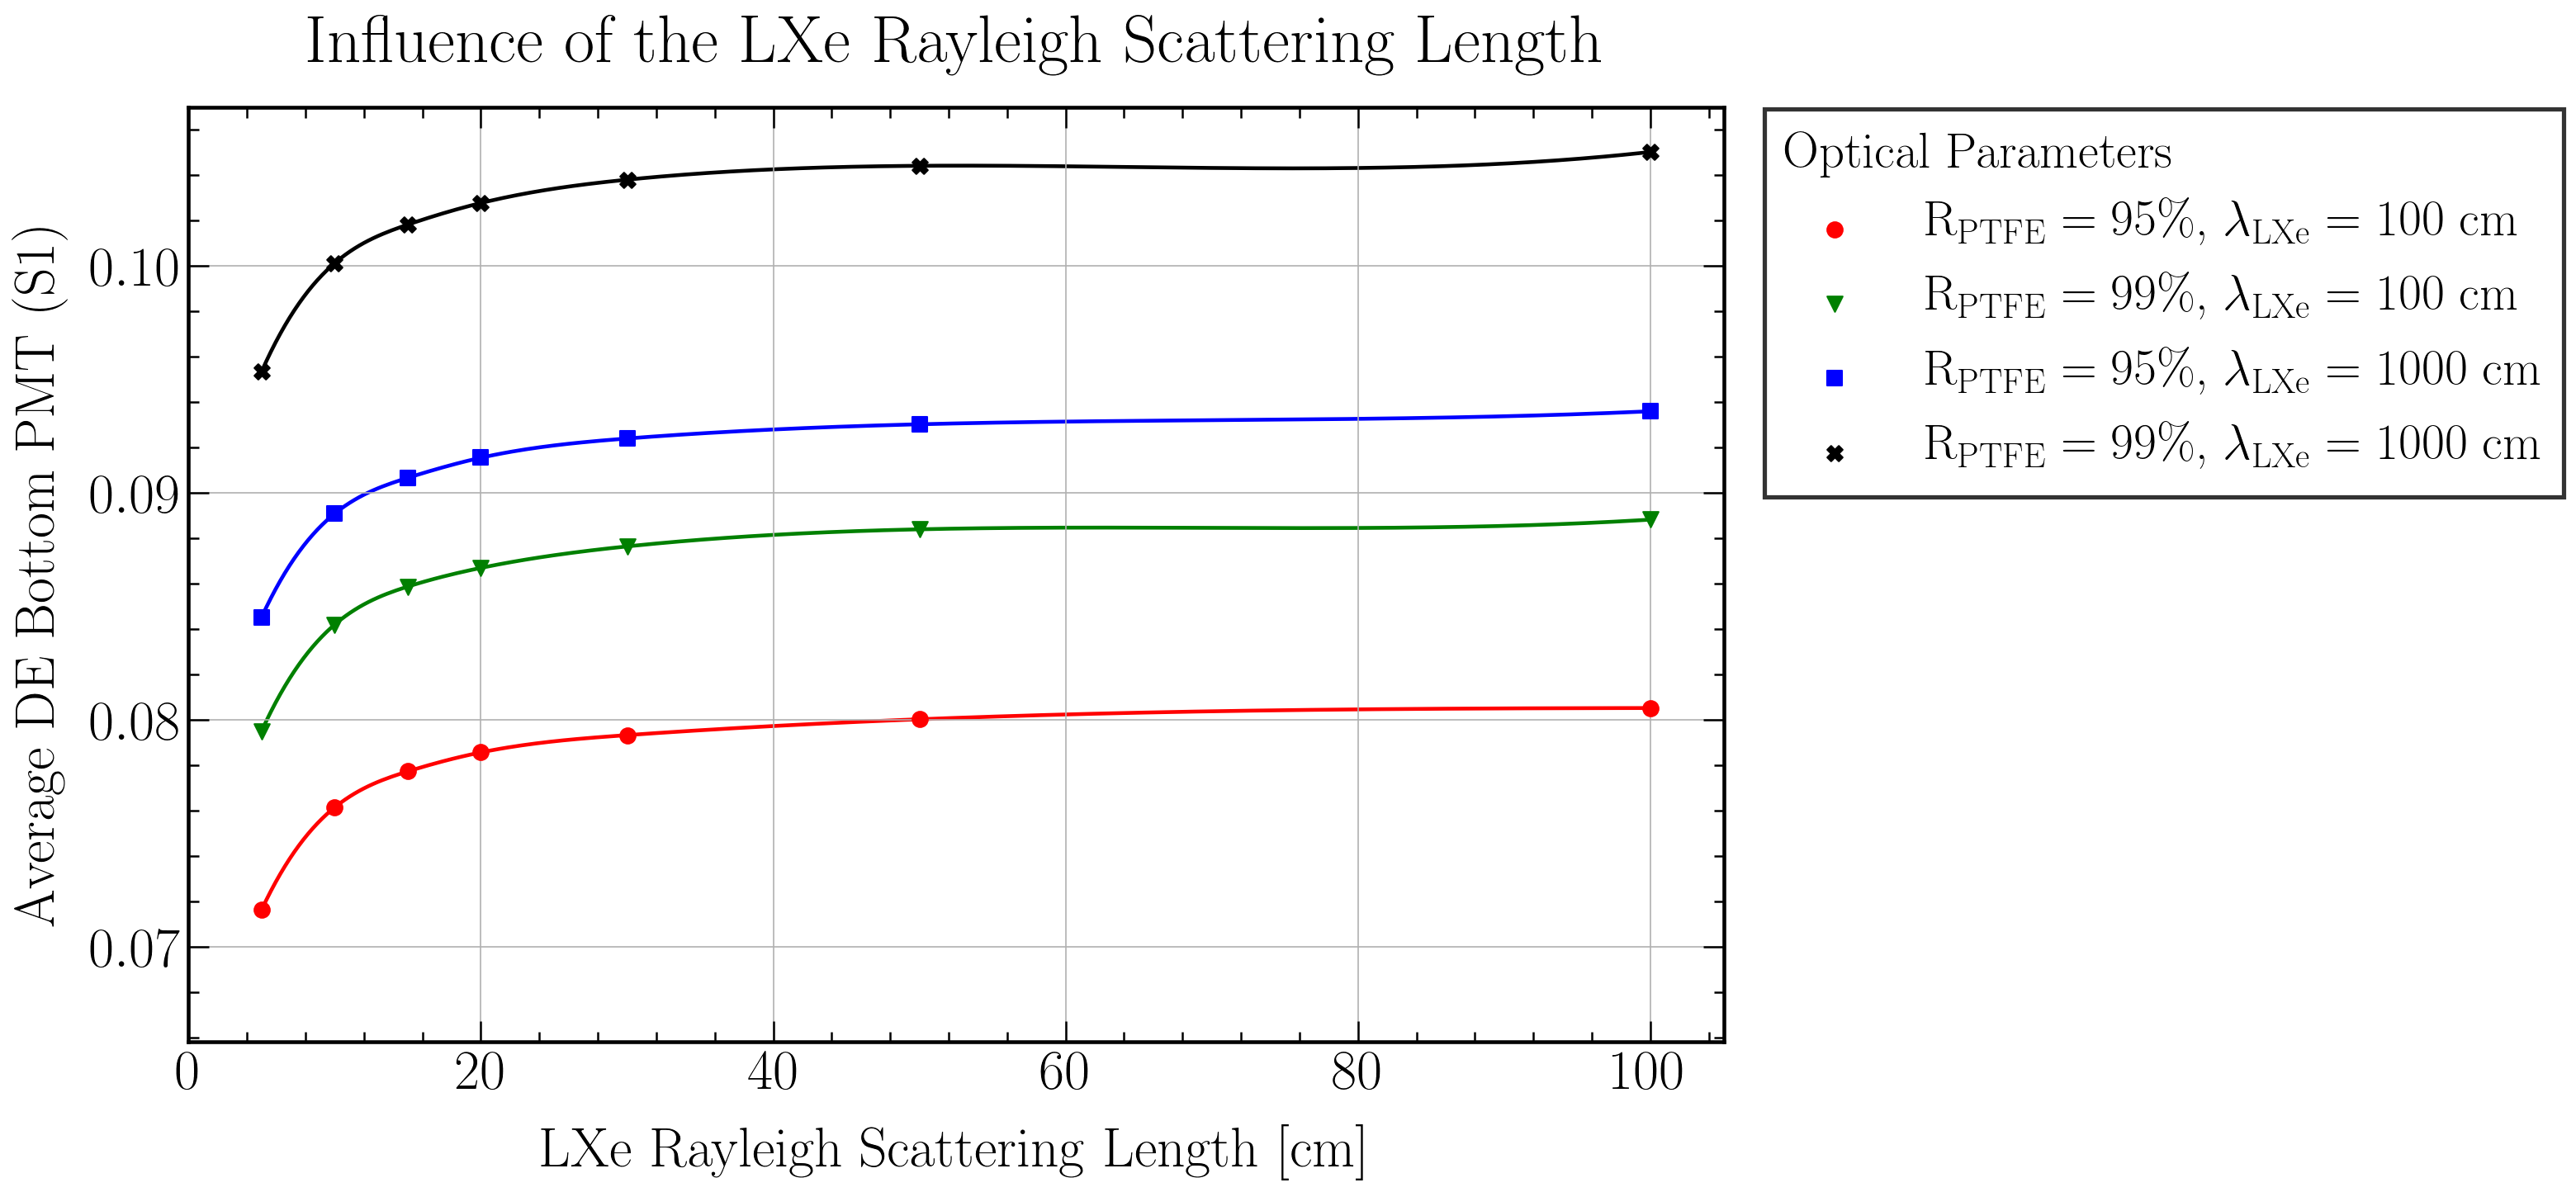

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT (S1)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_Bottom_spline.png", bbox_inches='tight')
plt.show()

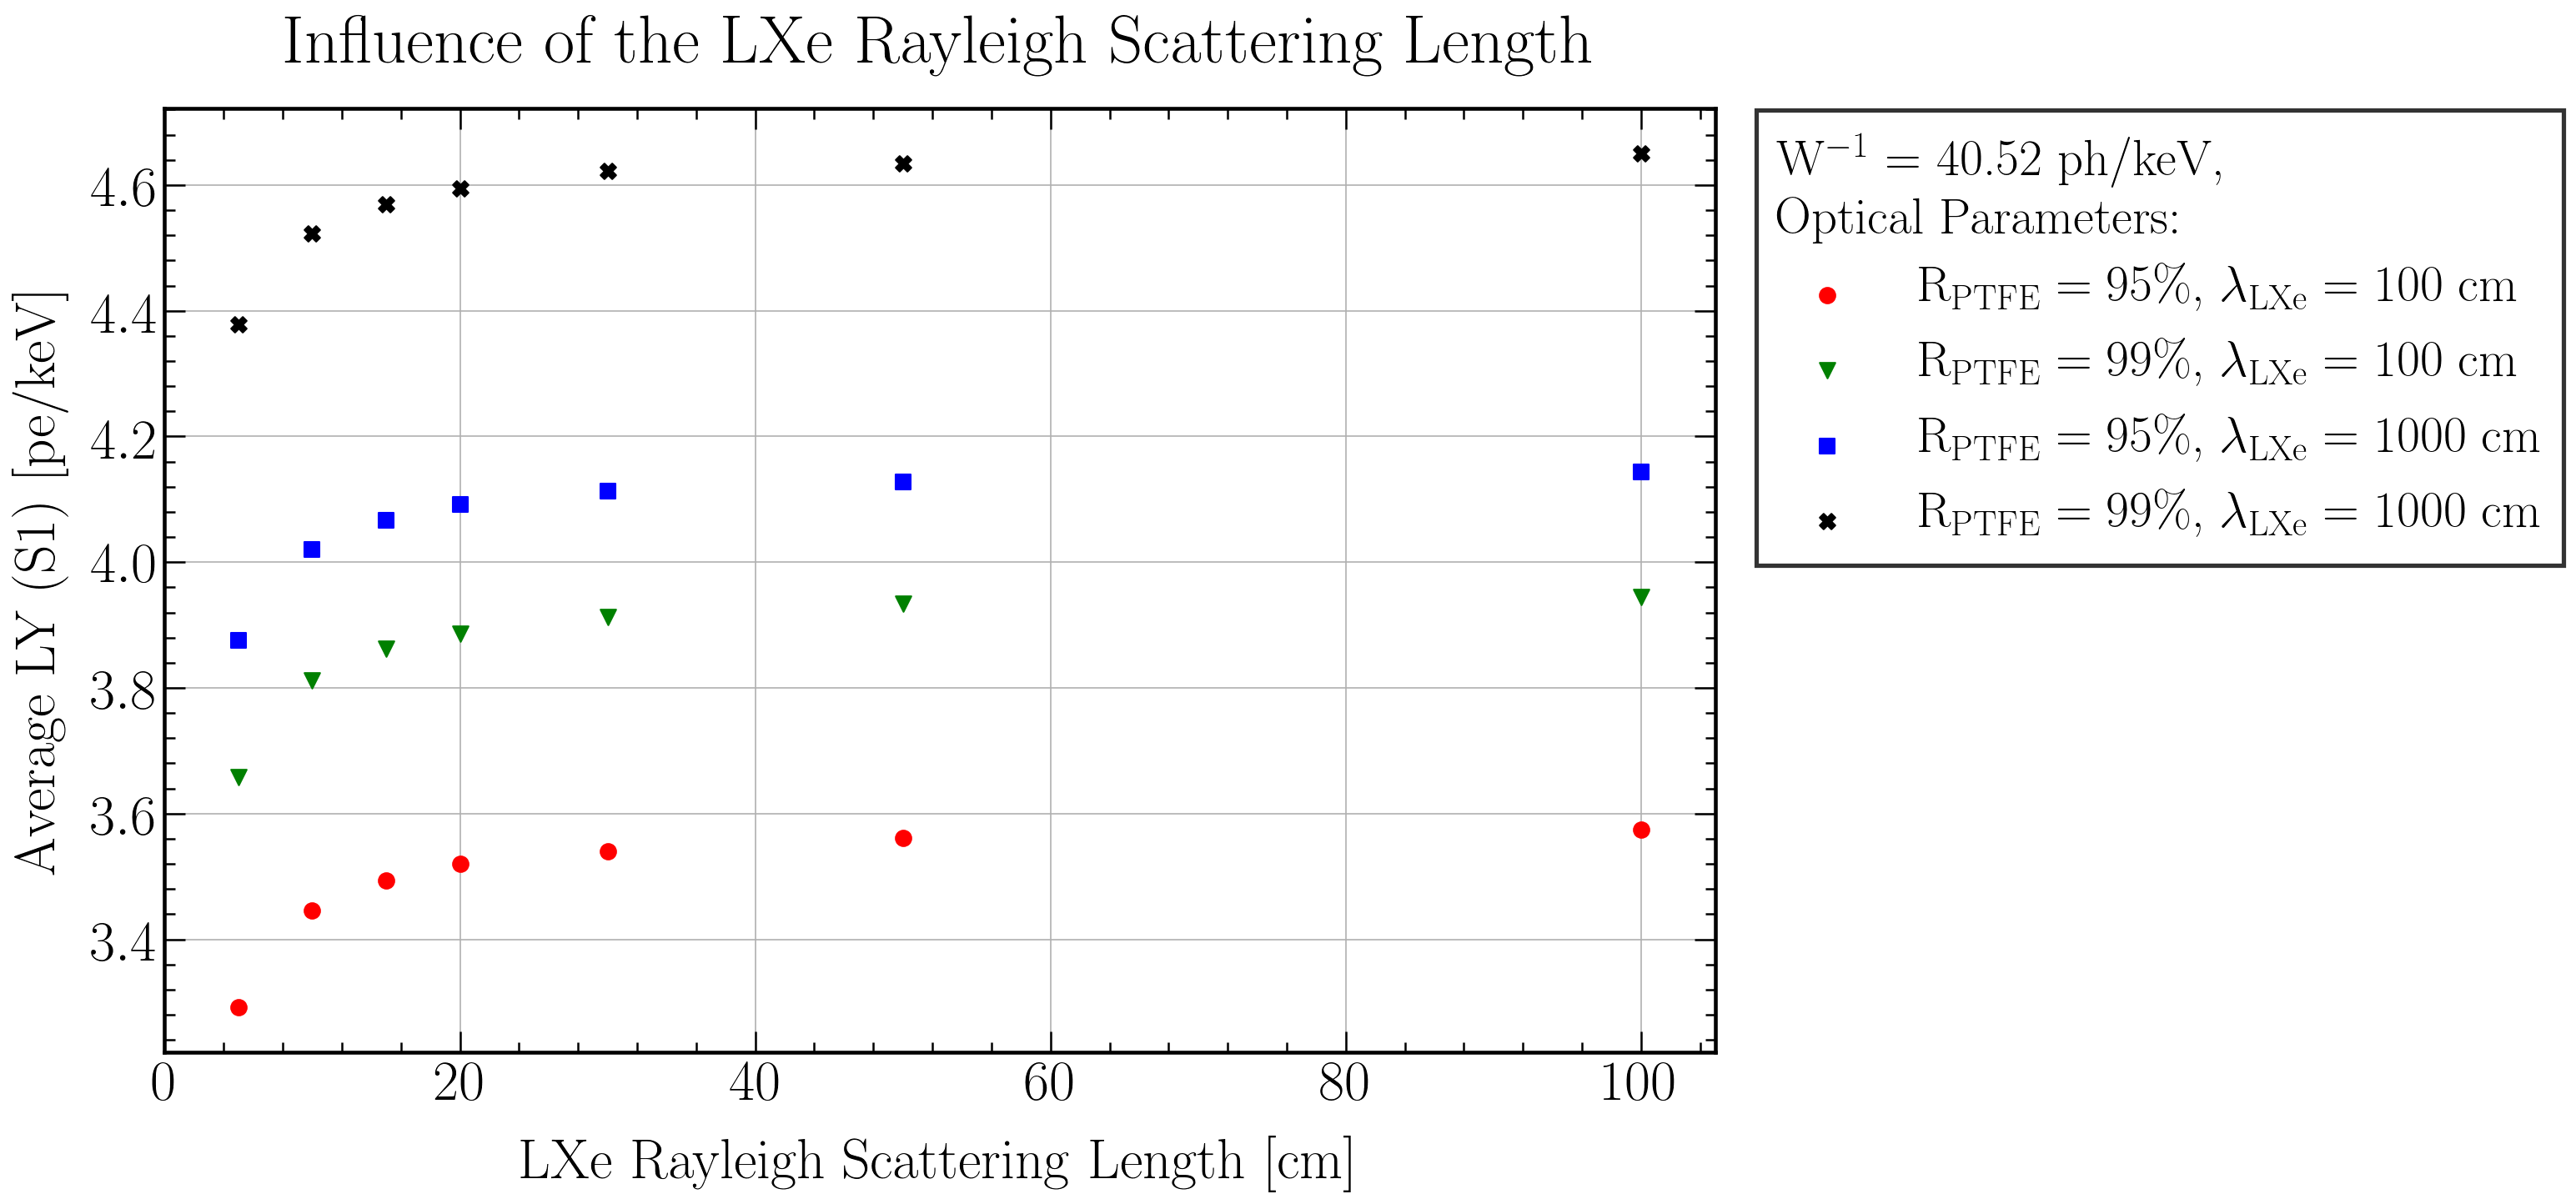

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S1) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY.png", bbox_inches='tight')
plt.show()

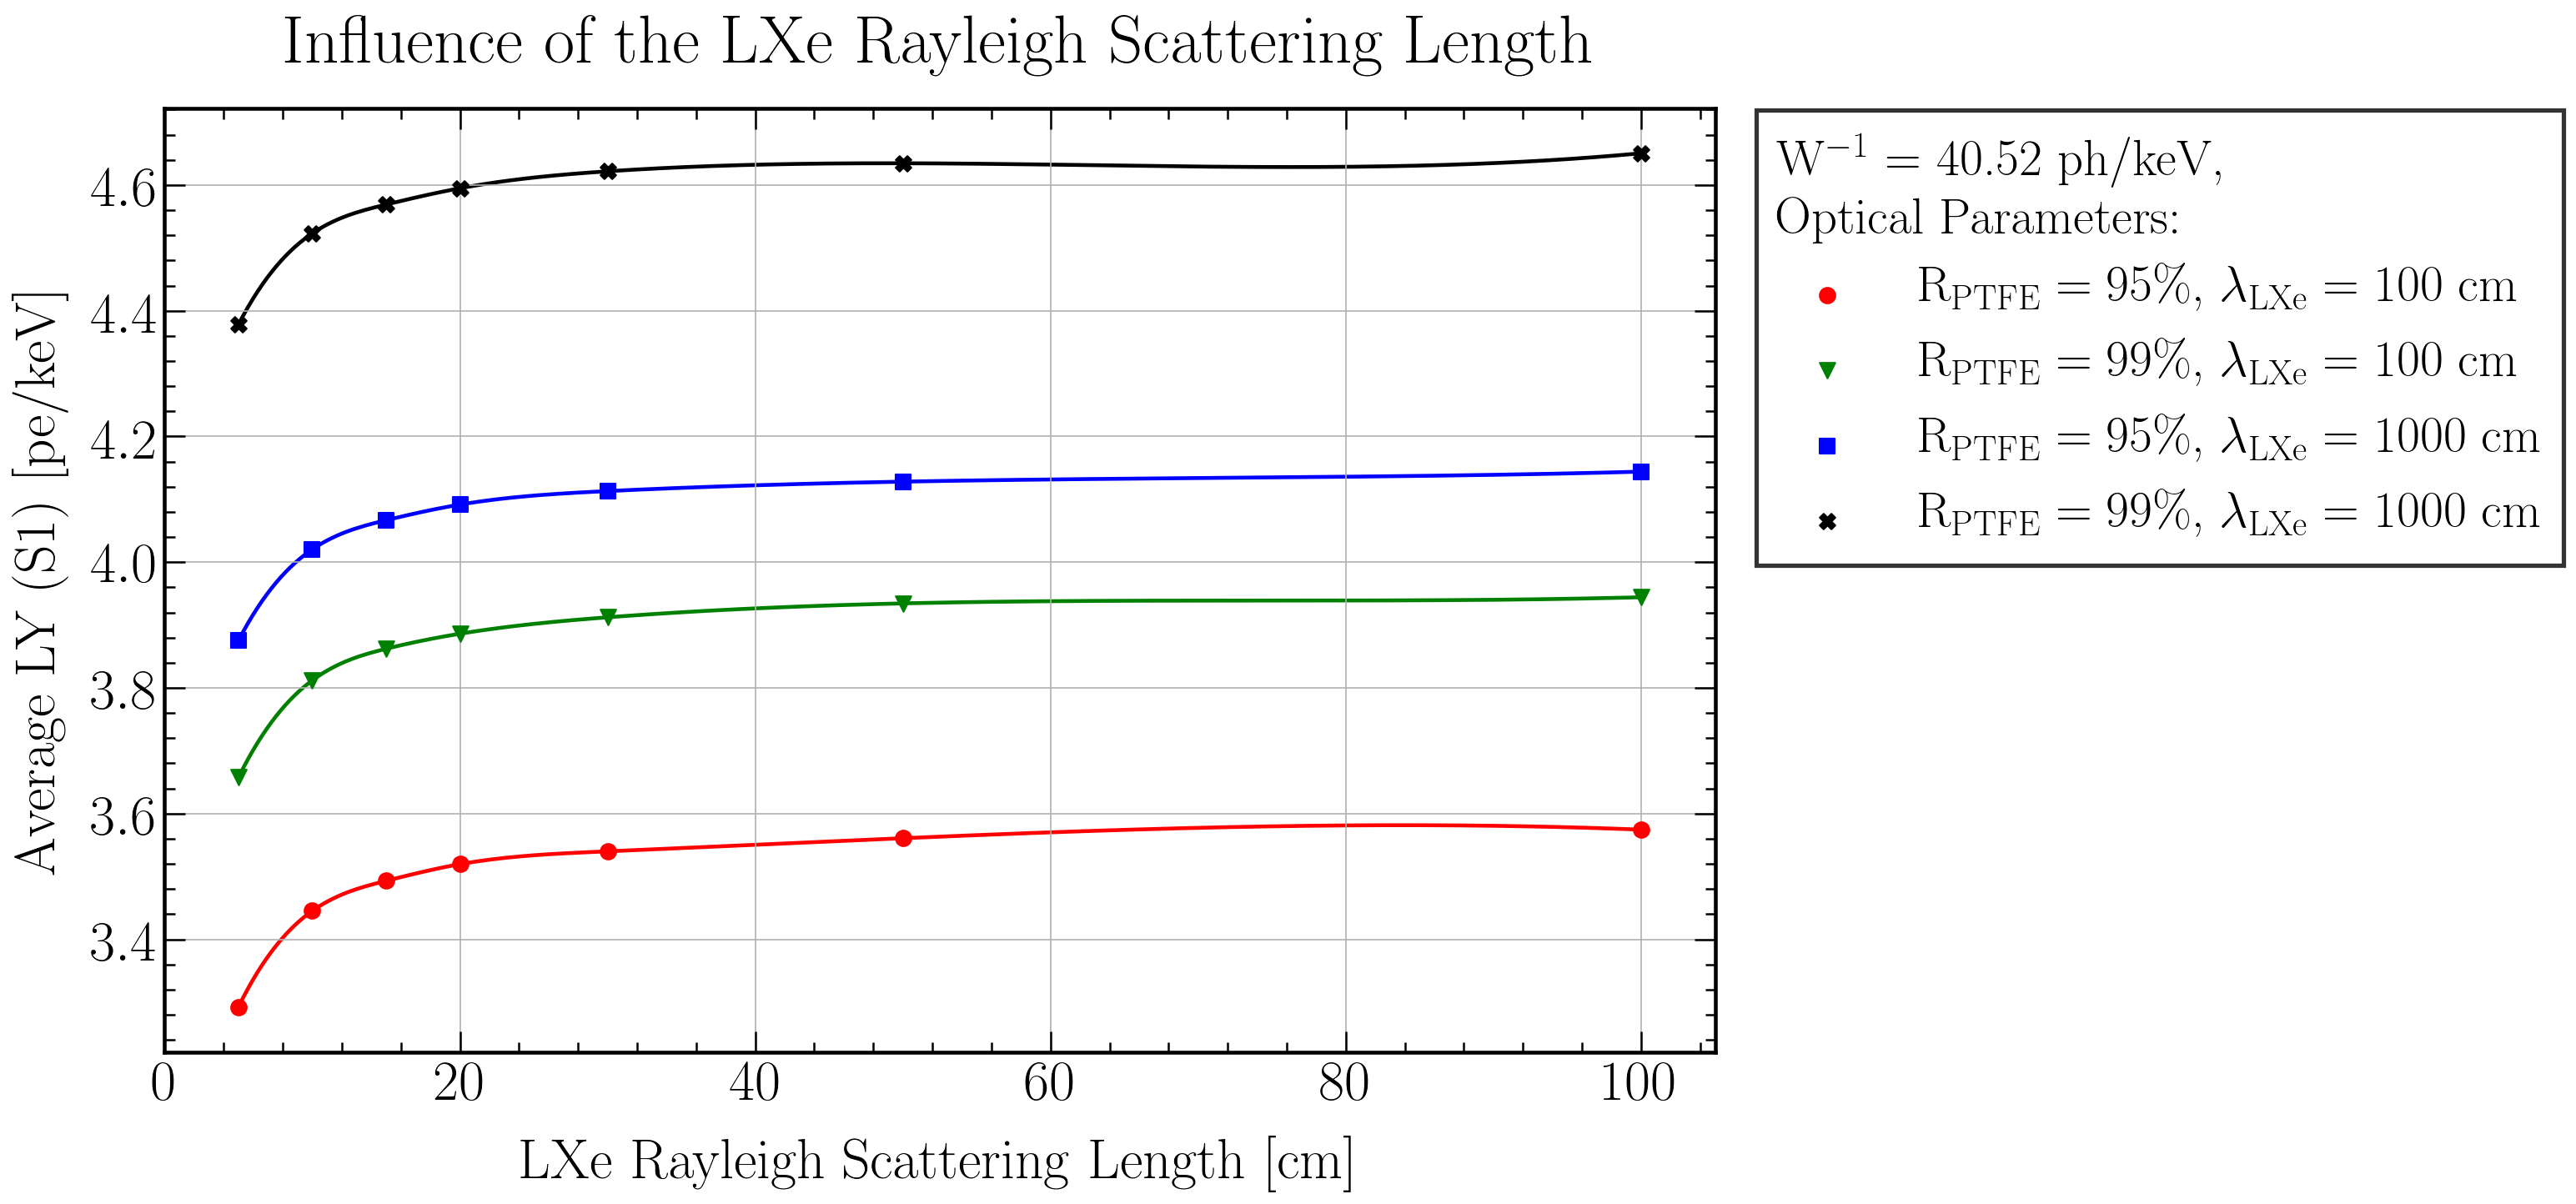

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S1) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY_spline.png", bbox_inches='tight')
plt.show()

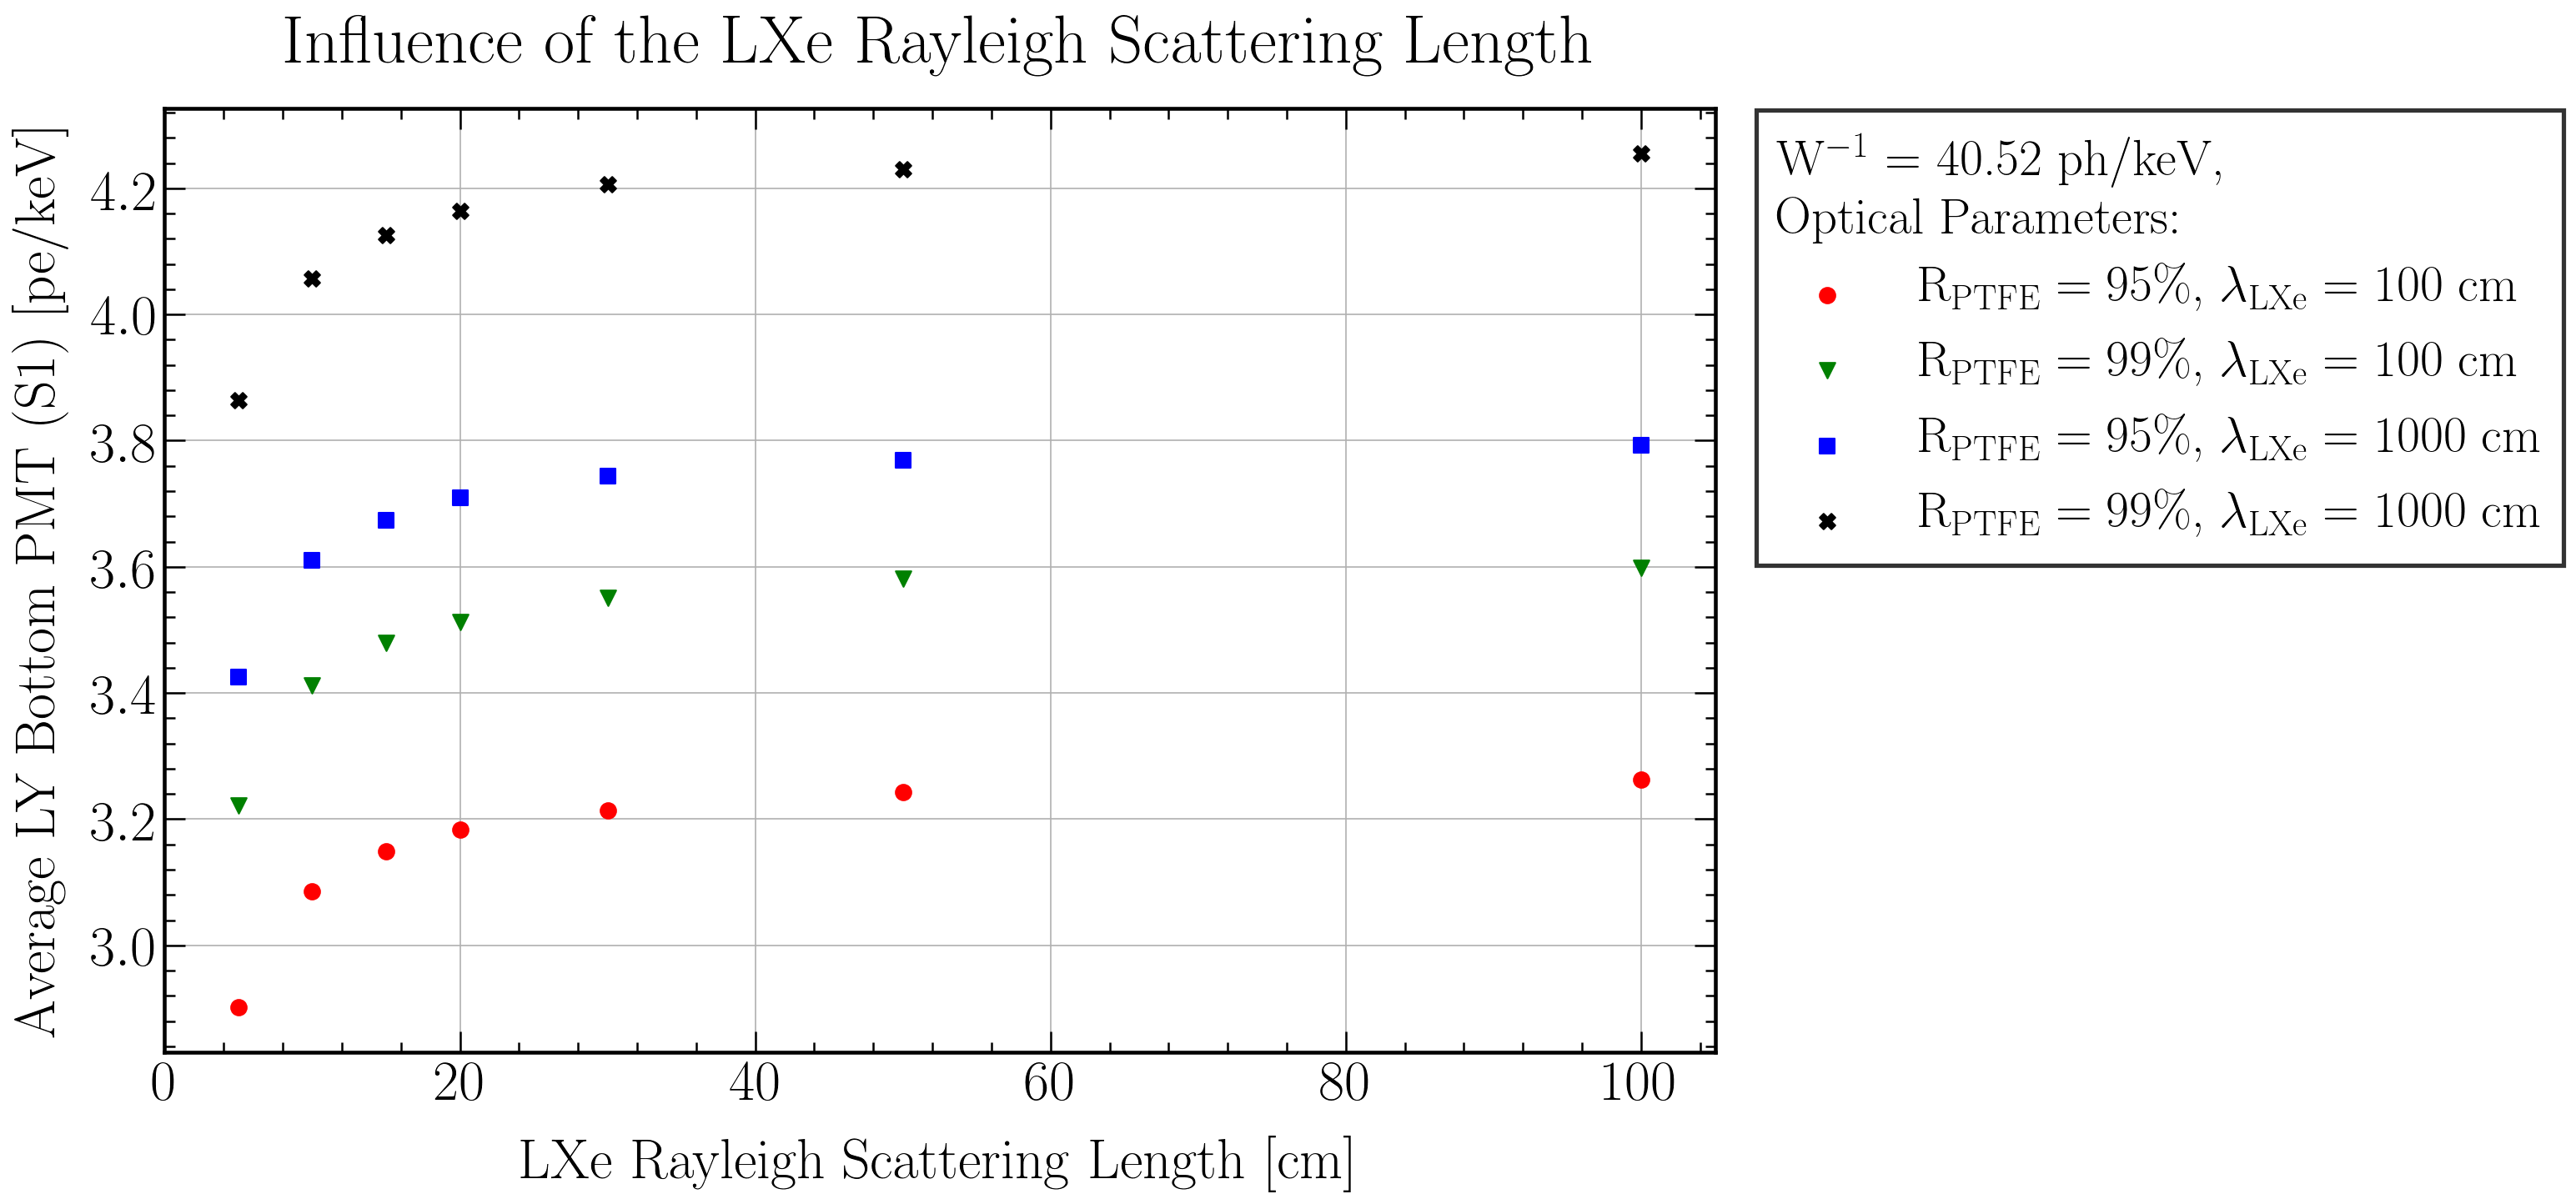

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S1) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY_Bottom.png", bbox_inches='tight')
plt.show()

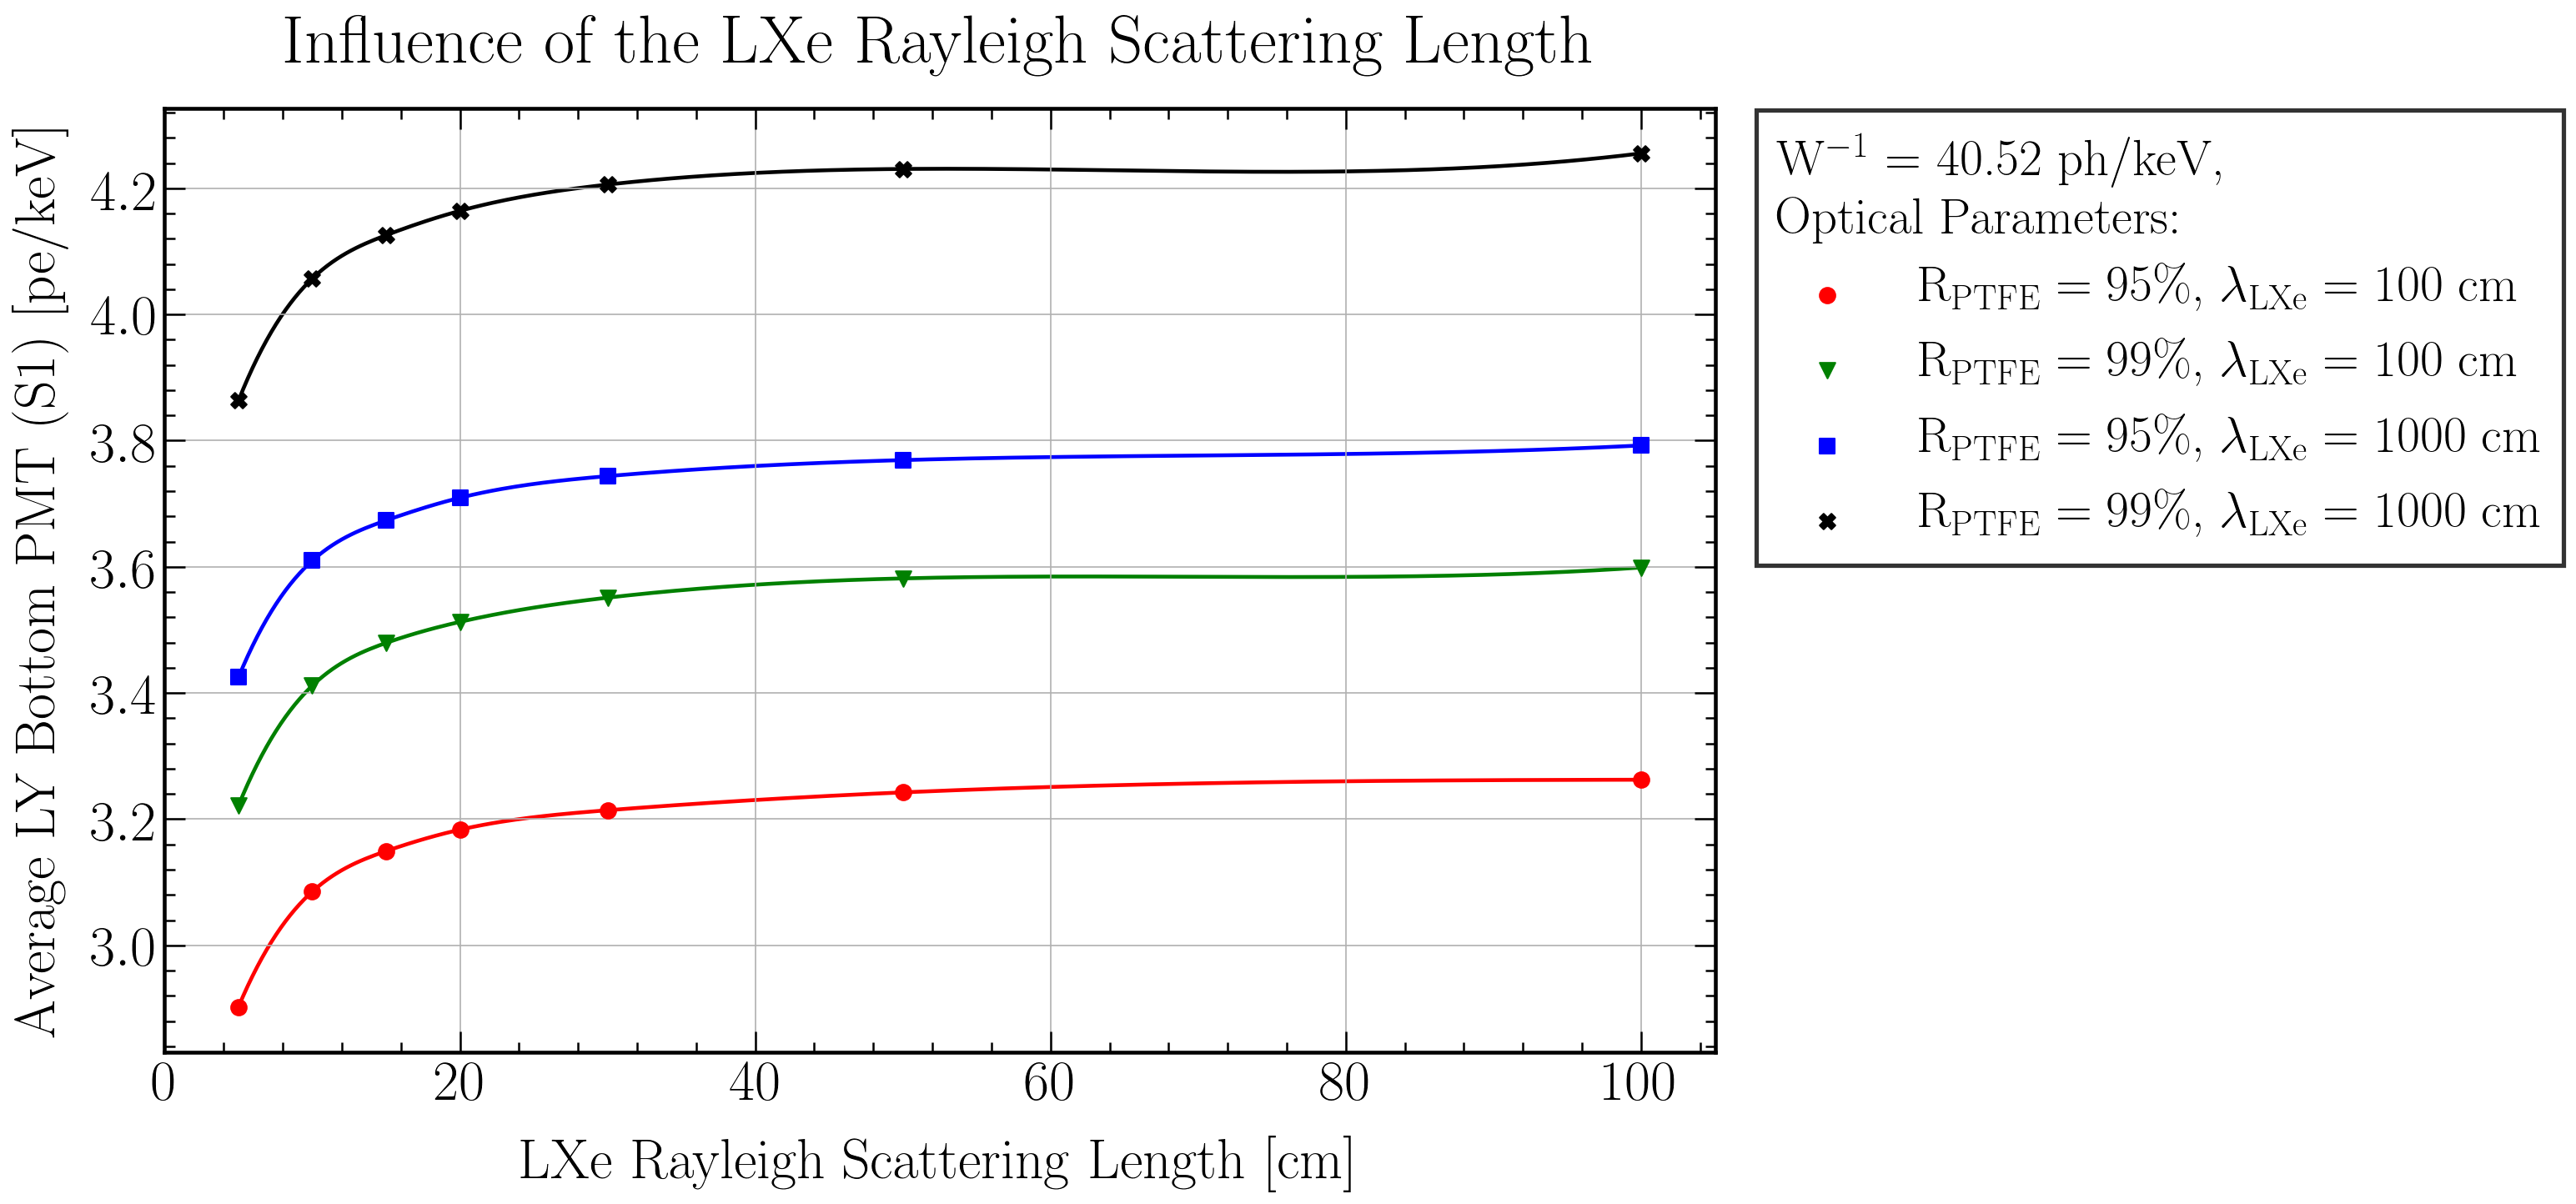

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S1) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY_Bottom_spline.png", bbox_inches='tight')
plt.show()

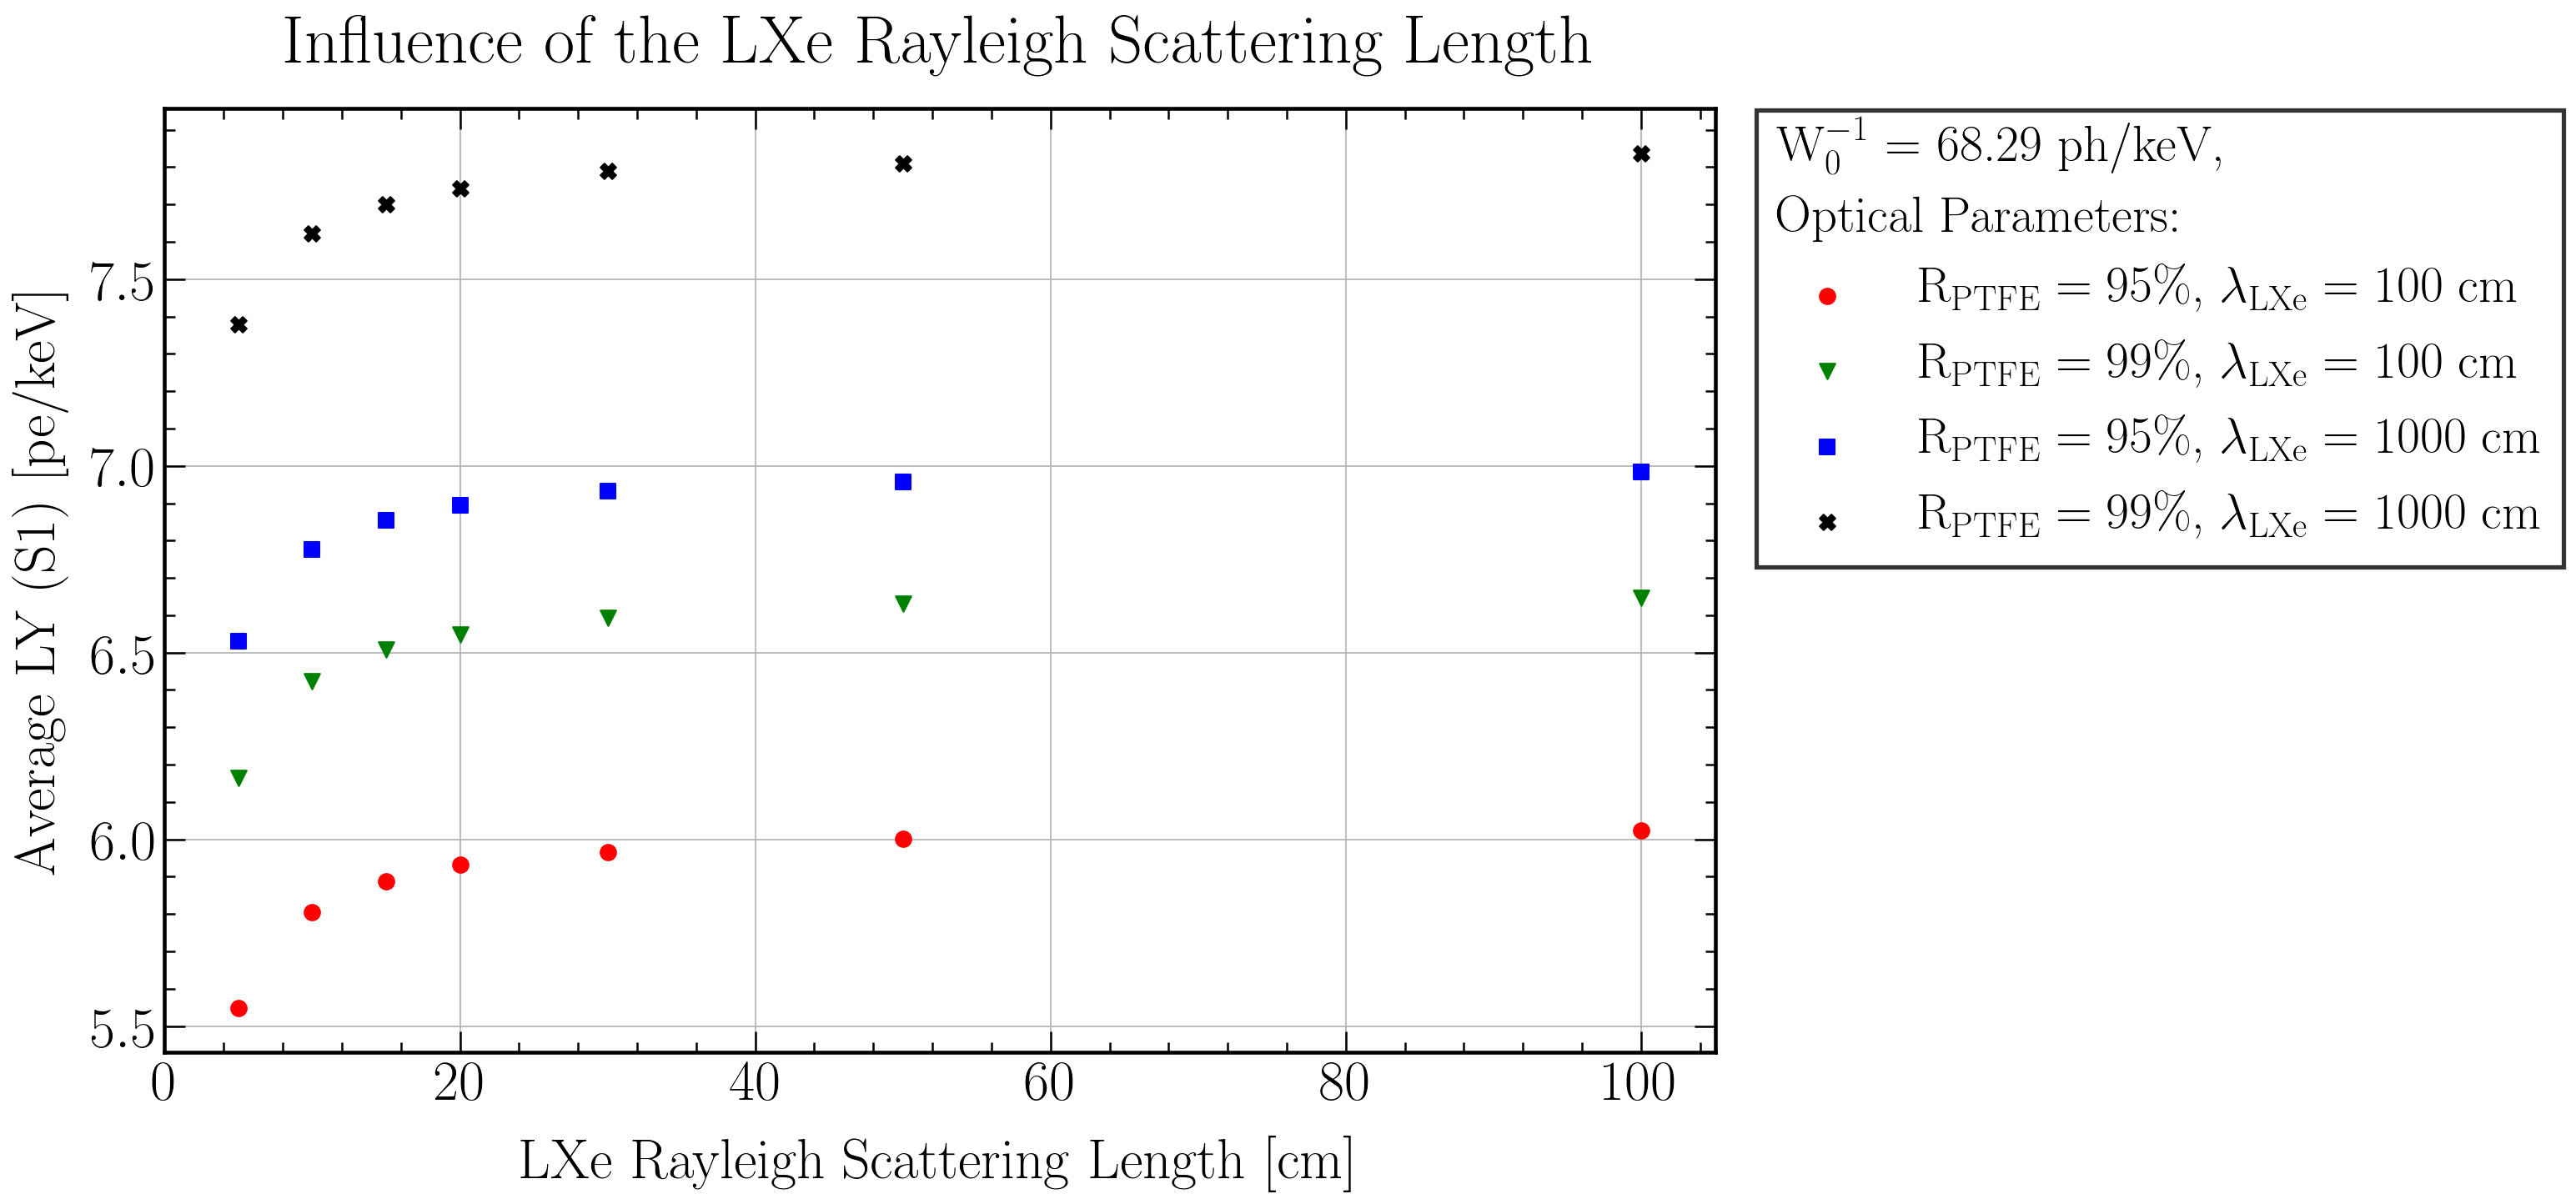

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S1) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0.png", bbox_inches='tight')
plt.show()

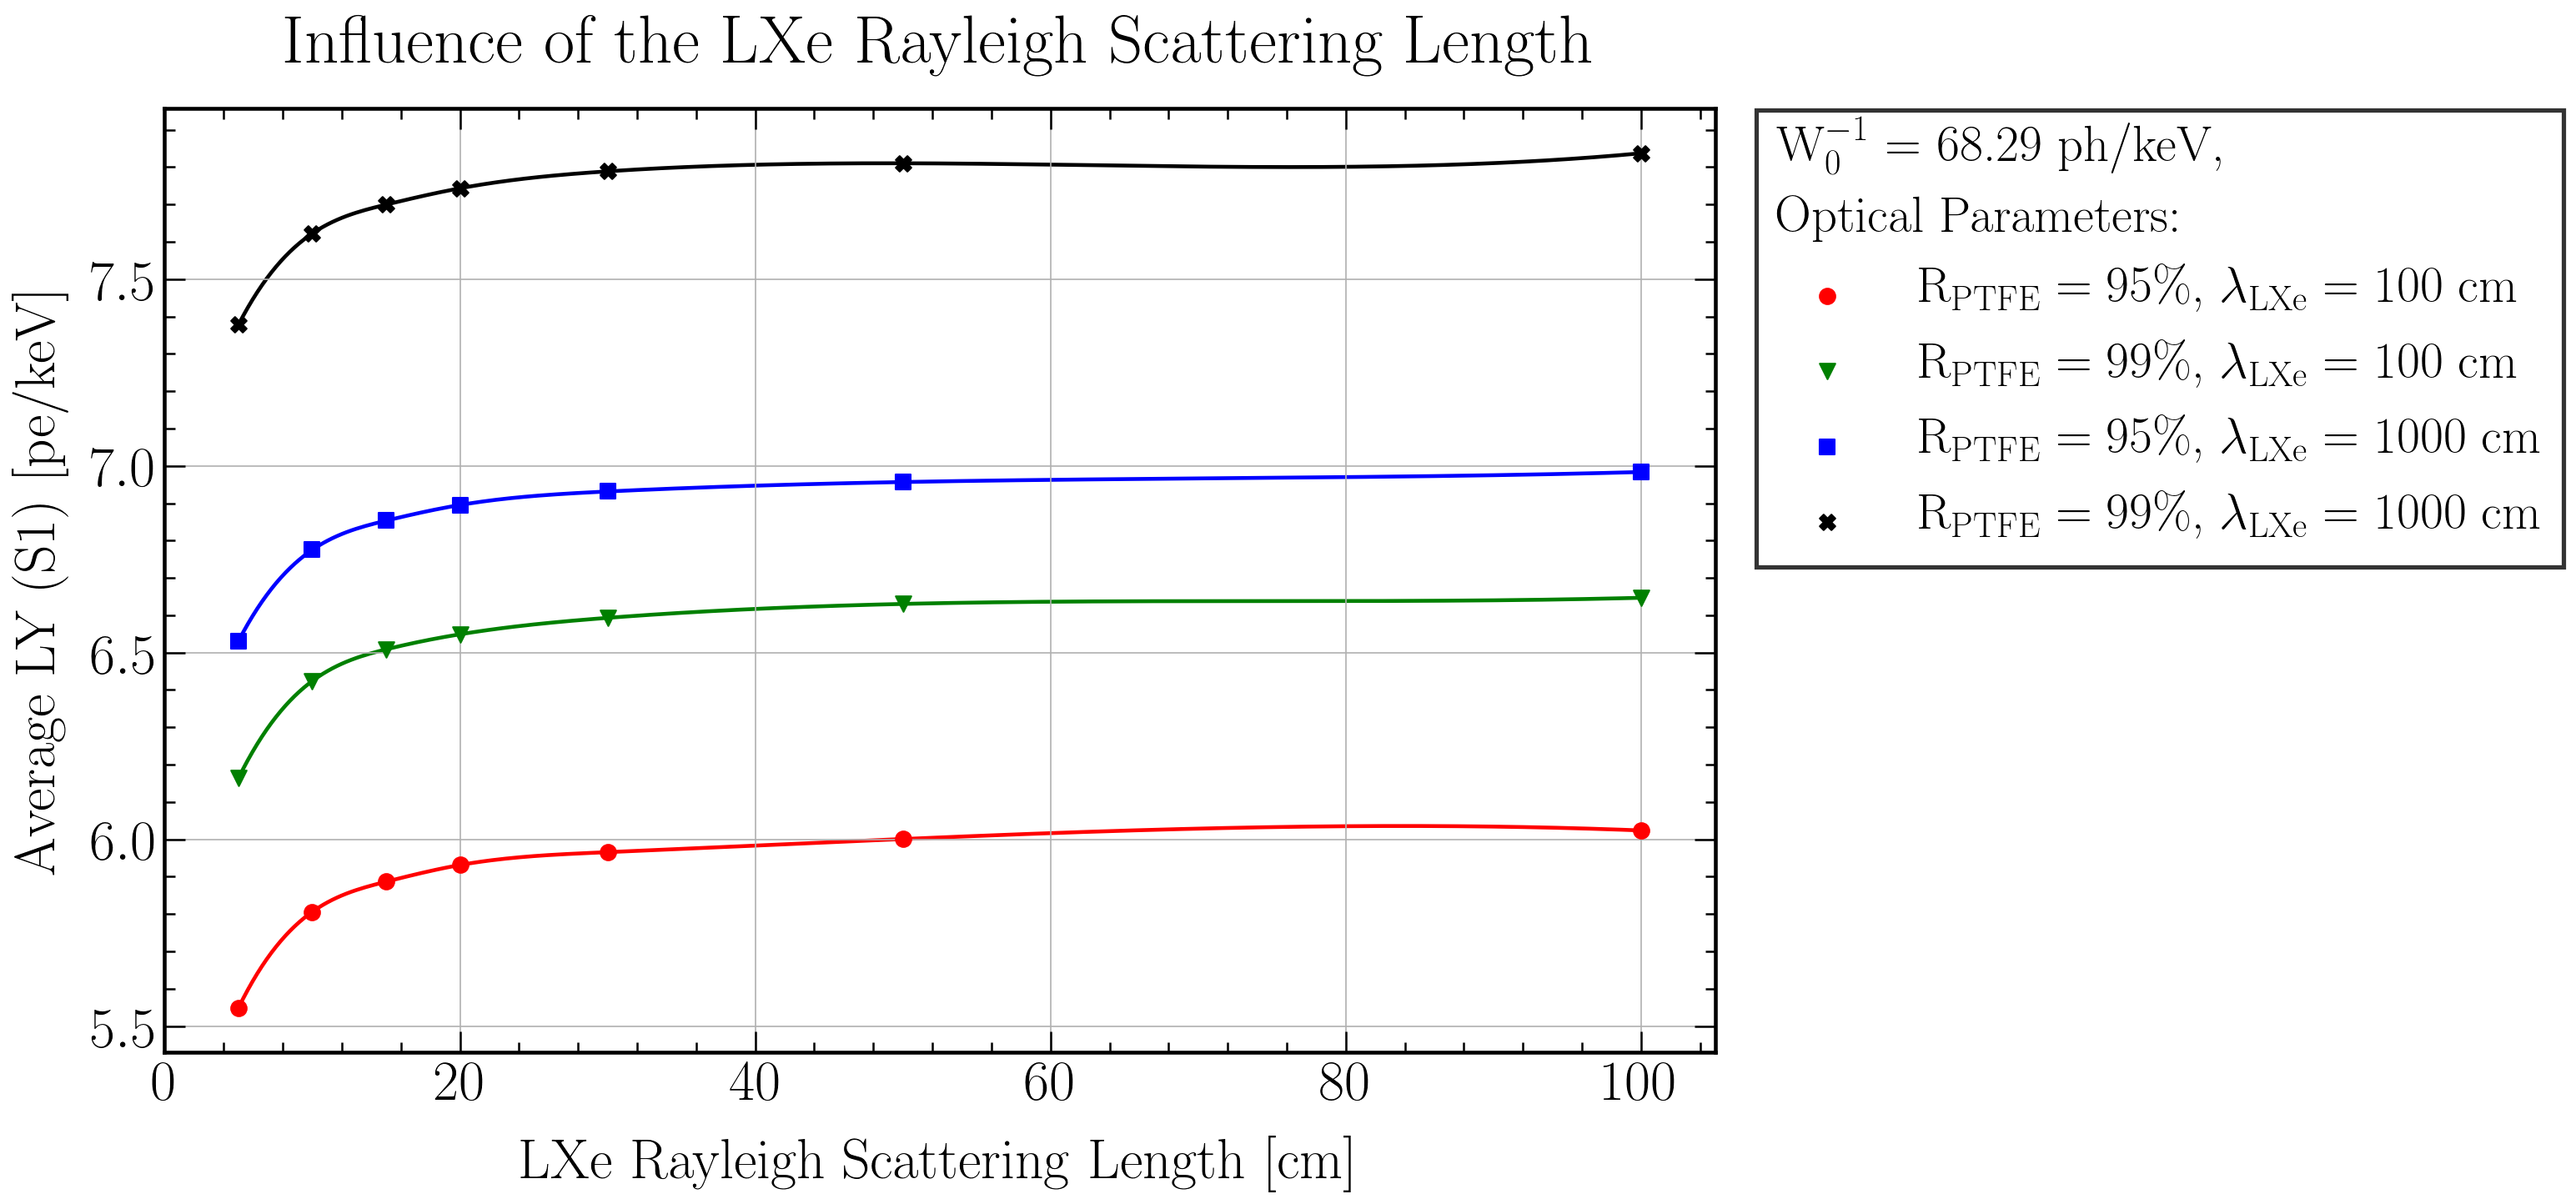

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S1) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0_spline.png", bbox_inches='tight')
plt.show()

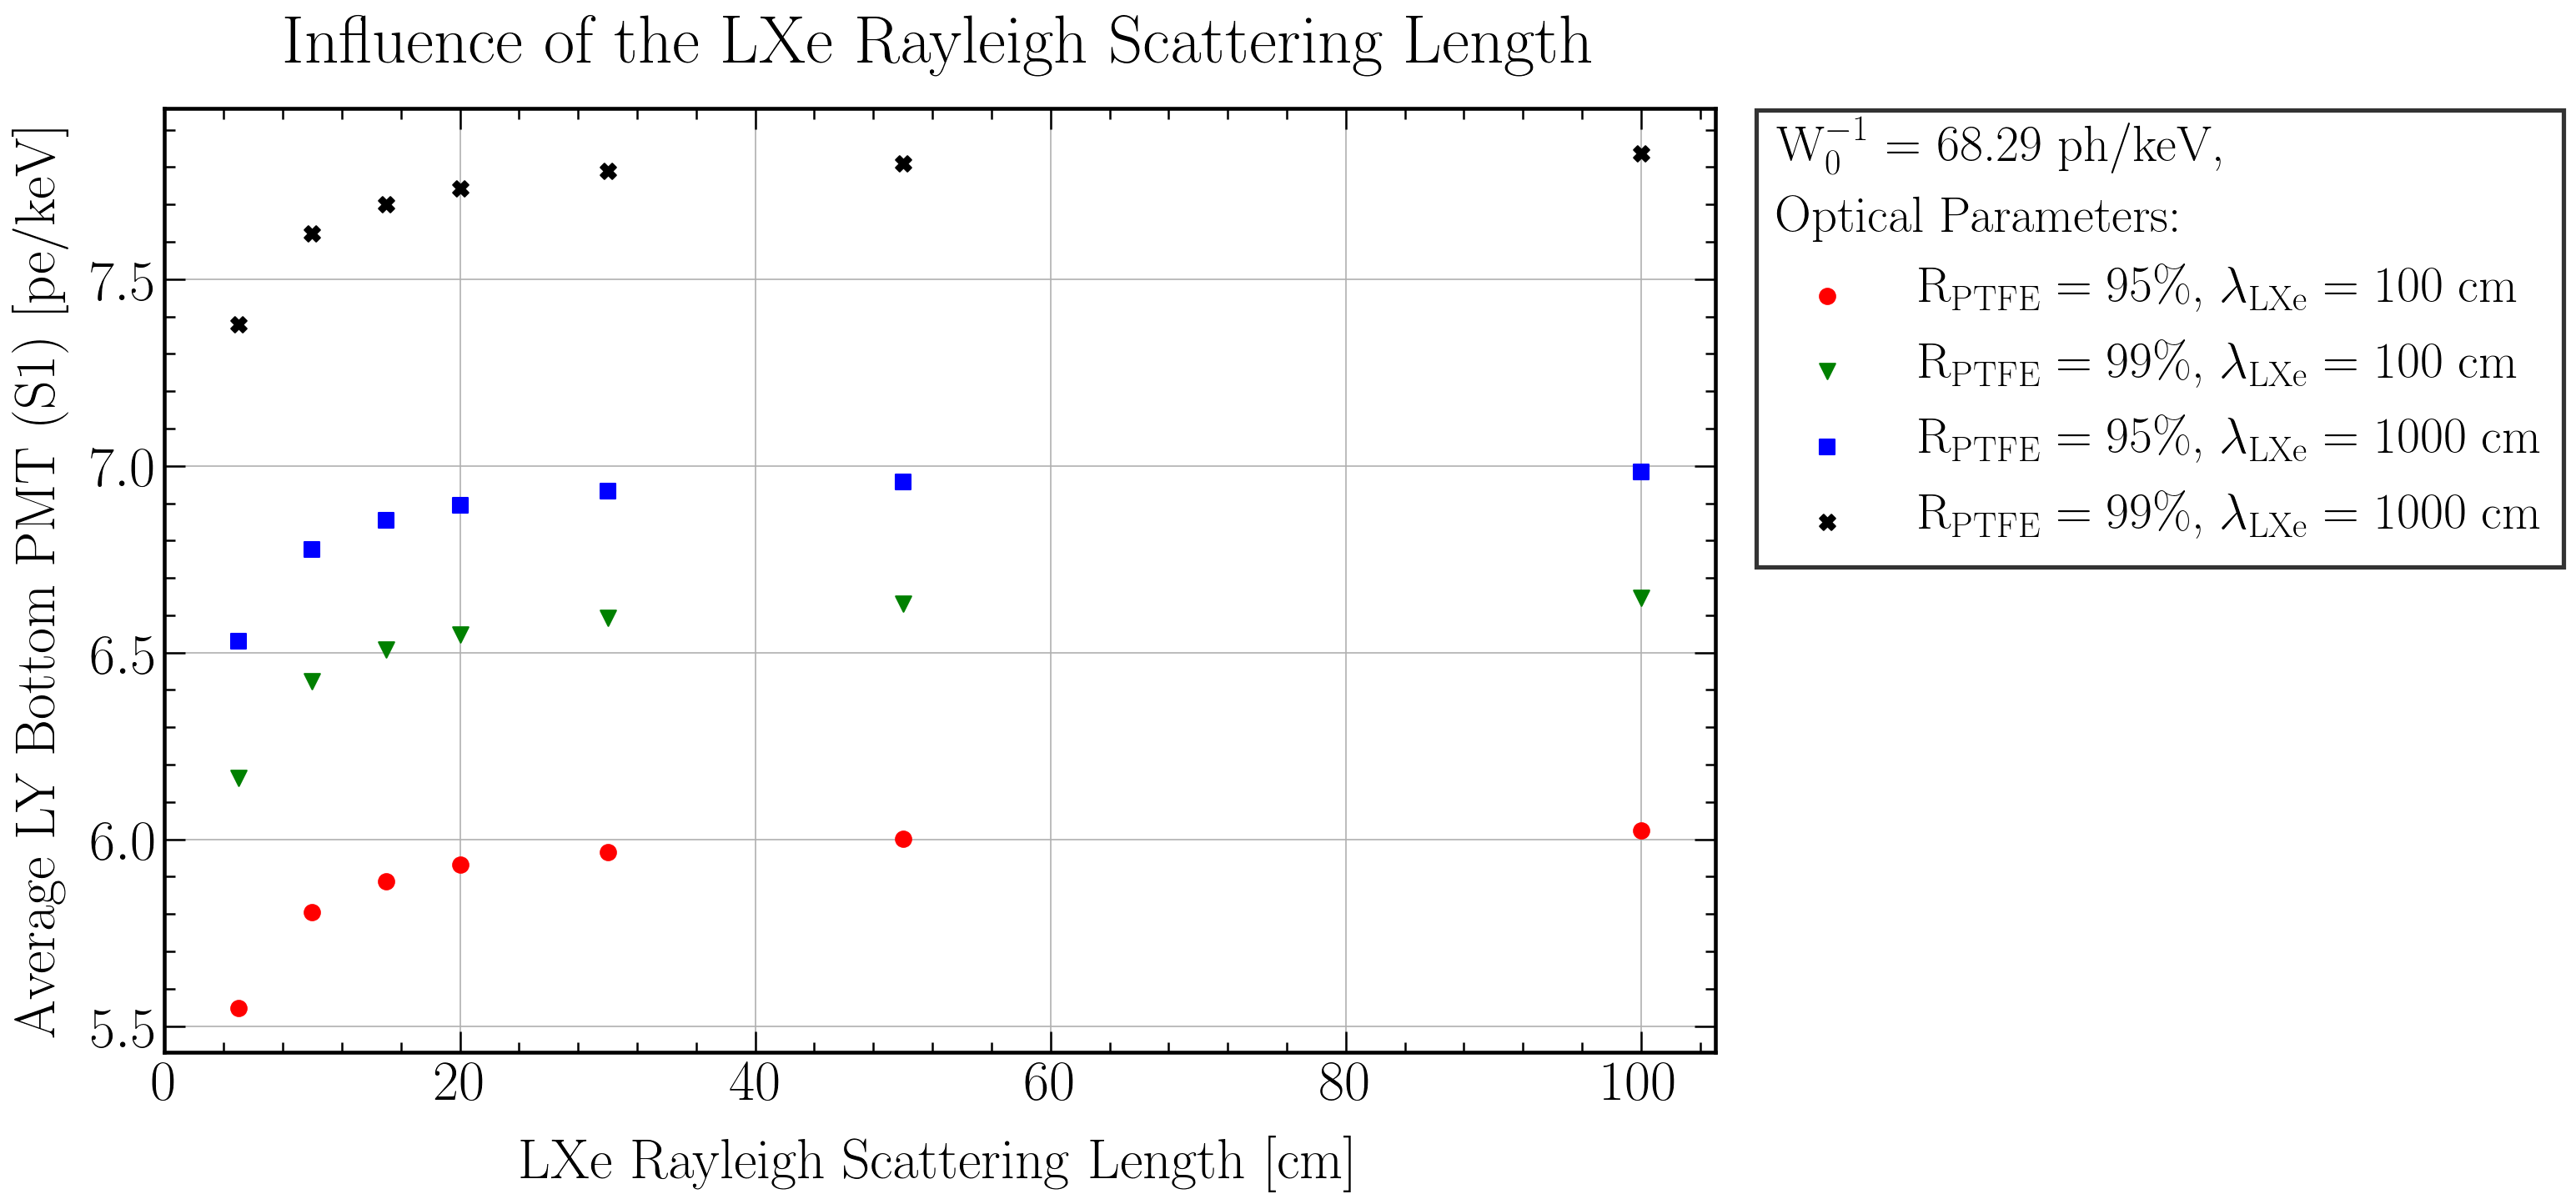

In [24]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S1) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0_Bottom.png", bbox_inches='tight')
plt.show()

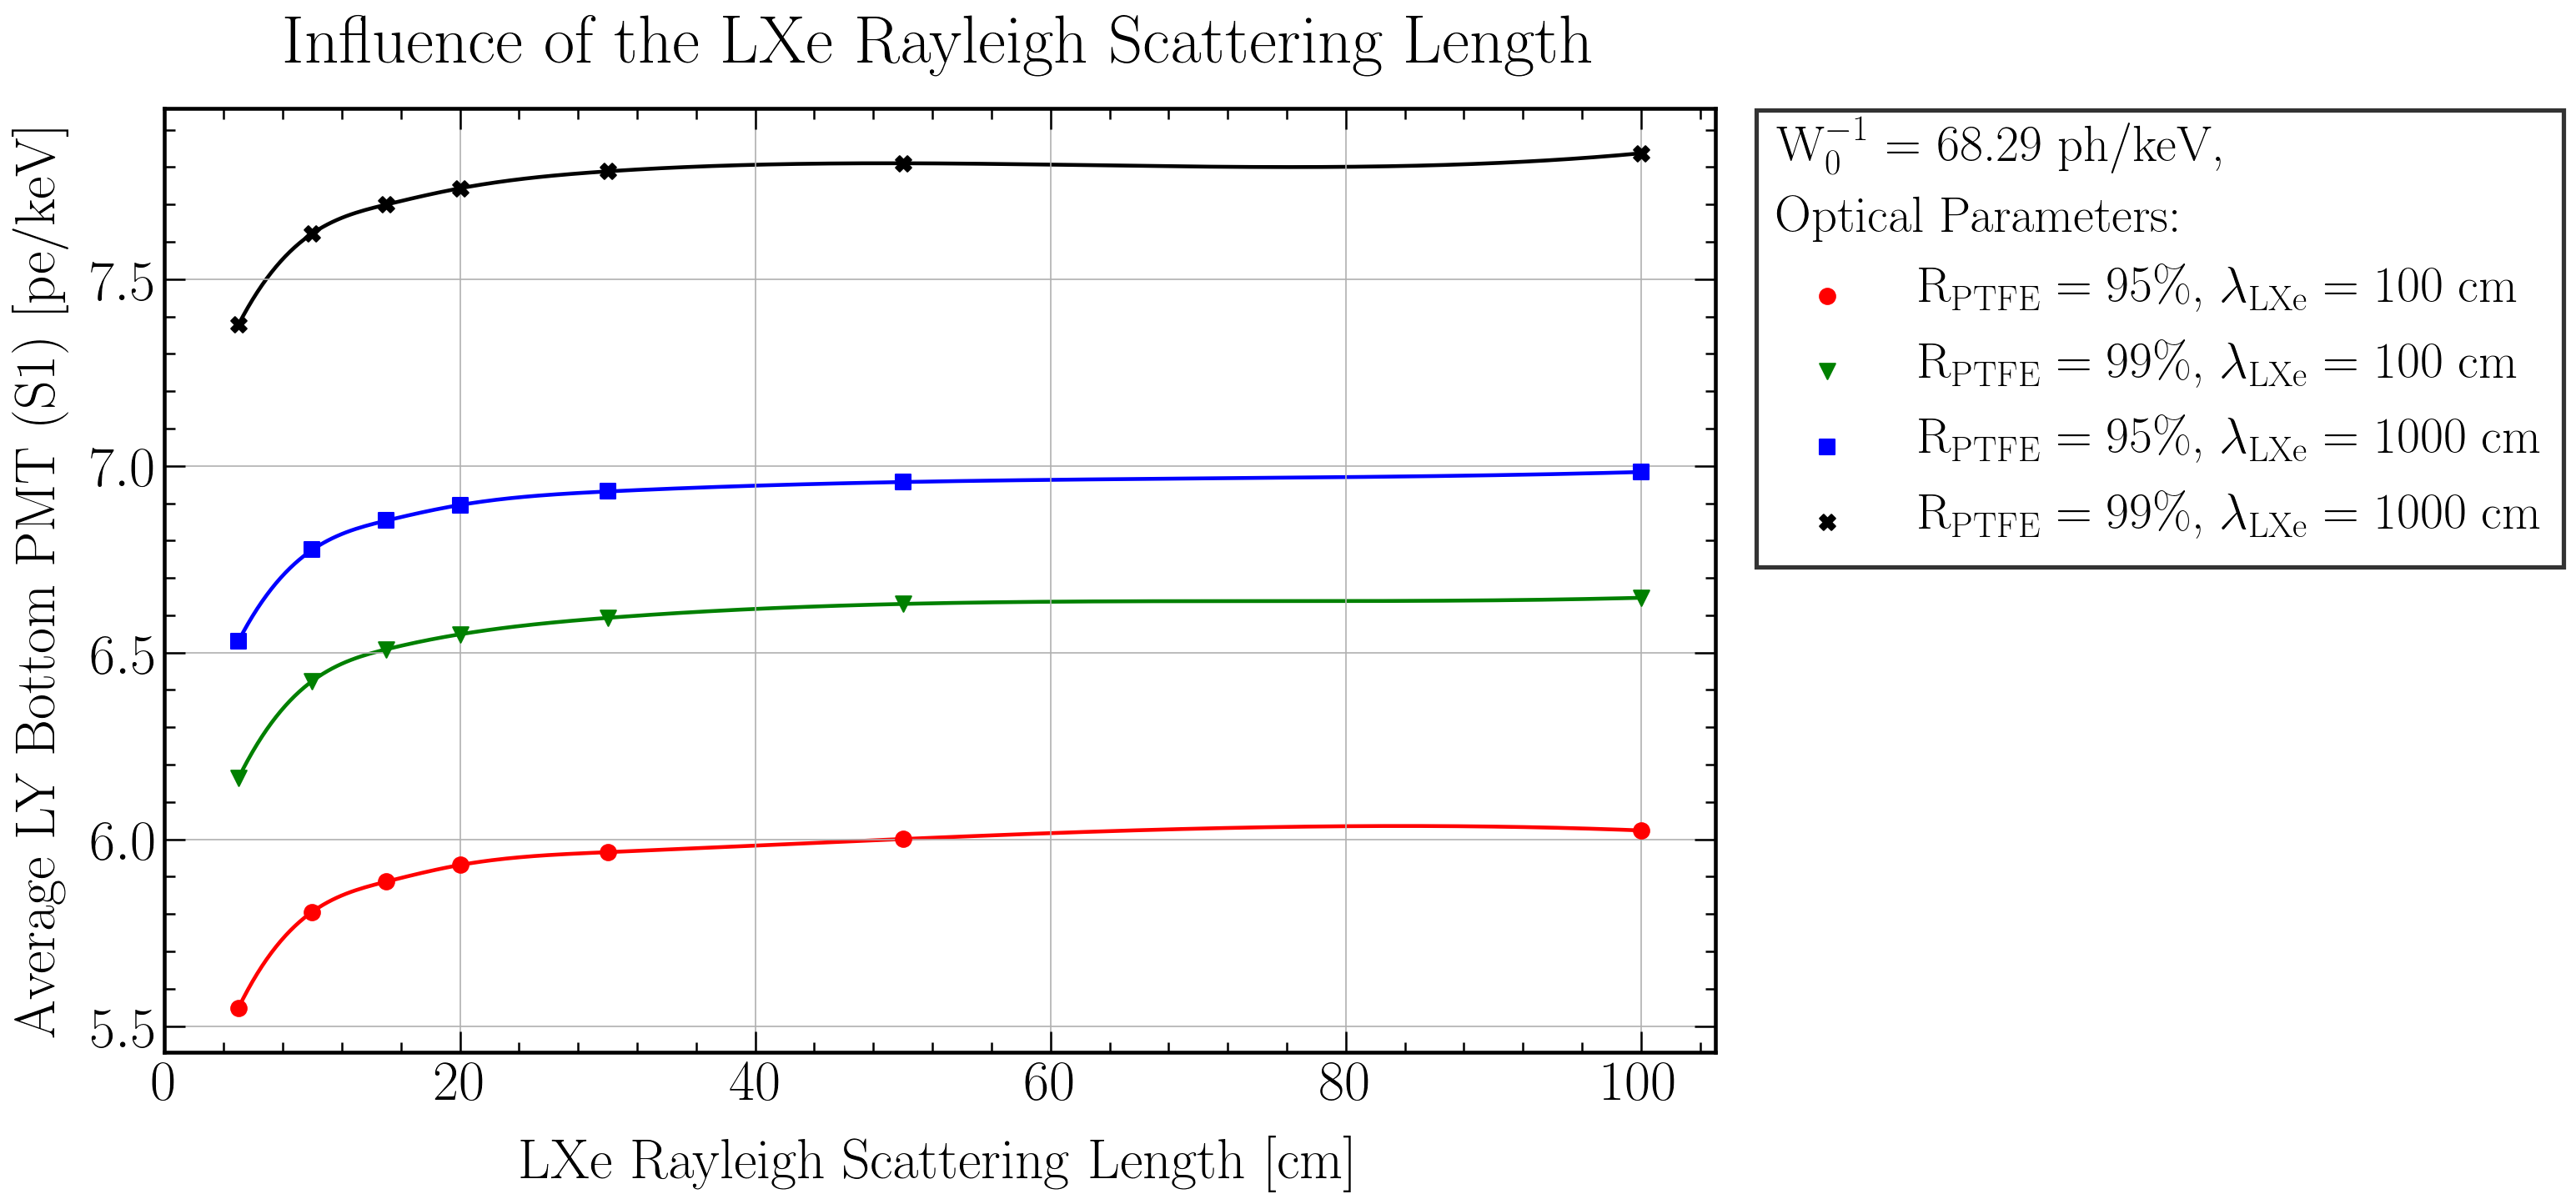

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S1) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0_Bottom_spline.png", bbox_inches='tight')
plt.show()